# 1) Installing required packages

In [ ]:
!pip install docplex
!pip install cplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.29.245-py3-none-any.whl size=685439 sha256=bdf1feb8925d2b6413eeed187e1d87acbb02e6427e3fca8227c0232fa01f2653
  Stored in directory: /root/.cache/pip/wheels/be/37/0a/5f5f9ed14d637a664ad676493d55654f655a099c7016808739
Successfully built docplex
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 12.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import math
import itertools
import networkx as nx
import ast
import time

In [2]:
import zipfile
import os
zip_path = "instancje.zip"
extract_dir = "./instancje"
output_dir = "./dane"

# 1. extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"extracted do: {extract_dir}")

extracted do: ./instancje


In [ ]:
from docplex.mp.model import Model
import cplex

m = Model(name="patched")
m.context.solver.agent = "cplex"

print("Solver agent:", m.context.solver.agent)

Solver agent: cplex


In [ ]:
import cplex

print("CPLEX version:", cplex.Cplex().get_version())

CPLEX version: 22.1.2.0


# 2) Dataset overview - creating Scenario 1 and Scenario 2

## 2.1) Scenario 1 - no. of targets > no. of weopons

In [ ]:
import os
import ast

input_dir = "./instancje/instancje"
output_dir = "./instancje_shrink"
os.makedirs(output_dir, exist_ok=True)

# keeping treshold: if is bigger than 1000 not available for cplex free version:
MAX_VARIABLES = 1000

for filename in os.listdir(input_dir):
    if filename.endswith(".dat"):
        filepath = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        with open(filepath, "r") as f:
            lines = f.readlines()

        N = int(lines[0])  # targets
        M = int(lines[1])  # weapon

        # check if instance is too big
        original_size = (2 * M) * N
        if original_size > MAX_VARIABLES:
            print(f"Instance: {filename} too big (N={N}, M={M}, vars={original_size}).")

            new_M = min(M, MAX_VARIABLES // (2 * N))
            if new_M < 1:
                new_M = 1
                new_N = MAX_VARIABLES // (2 * new_M)
                N = new_N
            M = new_M

            print(f"Cut to N={N}, M={M} (vars={(2*M)*N})")

        target_value = ast.literal_eval(lines[2])[:N]
        pk = ast.literal_eval("".join(lines[3:]))
        if isinstance(pk[0], list): pk = pk[:M]
        else:
            pk = pk[:M*N]

        # New .dat file (shrink)
        with open(output_path, "w") as f:
            f.write(f"{N}\n")
            f.write(f"{M}\n")
            f.write(f"{target_value}\n")  # aij
            f.write(f"{pk}")  # pk matrix

Instance: sonuc_bayir_wta70.dat too big (N=70, M=70, vars=9800).
Cut to N=70, M=7 (vars=980)
Instance: sonuc_bayir_wta200.dat too big (N=200, M=200, vars=80000).
Cut to N=200, M=2 (vars=800)
Instance: sonuc_bayir_wta50.dat too big (N=50, M=50, vars=5000).
Cut to N=50, M=10 (vars=1000)
Instance: sonuc_bayir_wta30_mod03.dat too big (N=30, M=30, vars=1800).
Cut to N=30, M=16 (vars=960)
Instance: sonuc_bayir_wta90.dat too big (N=90, M=90, vars=16200).
Cut to N=90, M=5 (vars=900)
Instance: sonuc_bayir_wta30.dat too big (N=30, M=30, vars=1800).
Cut to N=30, M=16 (vars=960)
Instance: sonuc_bayir_wta40.dat too big (N=40, M=40, vars=3200).
Cut to N=40, M=12 (vars=960)
Instance: sonuc_bayir_wta80.dat too big (N=80, M=80, vars=12800).
Cut to N=80, M=6 (vars=960)
Instance: sonuc_bayir_wta100_mod03.dat too big (N=100, M=100, vars=20000).
Cut to N=100, M=5 (vars=1000)
Instance: sonuc_bayir_wta80_mod03.dat too big (N=80, M=80, vars=12800).
Cut to N=80, M=6 (vars=960)
Instance: sonuc_bayir_wta60_mod03

## 2.2) Scenario 1 - no. of targets < no. of weopons

In [ ]:
import os
import ast
import numpy as np

def load_and_shrink_instance_V2(filepath, max_variables=1000):
    with open(filepath, "r") as f:
        lines = f.readlines()

    N = int(lines[0])
    M = int(lines[1])
    target_value = ast.literal_eval(lines[2])
    pk = ast.literal_eval("".join(lines[3:]))

    if not isinstance(pk[0], list):
        pk = [pk[i*N:(i+1)*N] for i in range(M)]

    target_value = np.array(target_value)
    pk = np.array(pk)

    original_vars = 2 * M * N
    if original_vars <= max_variables:
        print(f"Cut to N={N}, M={M} (vars={2 * N * M})")
        return N, M, target_value.tolist(), pk.tolist()

    mean_proba_i = pk.mean(axis=1)
    global_mean_proba = mean_proba_i.mean()
    weapon_scores = np.abs(mean_proba_i - global_mean_proba)
    weapon_ranking = np.argsort(weapon_scores)

    mean_target_value = target_value.mean()
    target_scores = np.abs(target_value - mean_target_value)
    target_ranking = np.argsort(target_scores)

    ratio = N / M
    new_M = M
    new_N = N

    while (2 * new_M * new_N) > max_variables:
        if new_M > 1:
            new_M -= 1
            new_N = max(1, int(round(ratio * new_M)))
        elif new_N > 1:
            new_N -= 1
        else:
            break

    selected_weapons = weapon_ranking[:new_M]
    selected_targets = target_ranking[:new_N]

    pk_shrunk = pk[selected_weapons][:, selected_targets]
    target_value_shrunk = target_value[selected_targets]
    print(f"Cut to N={new_N}, M={new_M} (vars={2 * new_M * new_N})")

    return new_N, new_M, target_value_shrunk.tolist(), pk_shrunk.tolist()

def save_instance_to_dat(filepath, N, M, target_value, pk):
    with open(filepath, "w") as f:
        f.write(f"{N}\n")
        f.write(f"{M}\n")
        f.write(f"{target_value}\n")
        f.write(f"{pk}\n")

# dirs / paths
input_dir = "/content/instancje/instancje"
output_dir = "/content/instancje_shrink"
os.makedirs(output_dir, exist_ok=True)

# processing each .dat file
for filename in os.listdir(input_dir):
    if filename.endswith(".dat"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        try:
            N, M, target_value, pk = load_and_shrink_instance_V2(input_path)
            save_instance_to_dat(output_path, N, M, target_value, pk)
            print(f"Saved: {output_path}")
        except Exception as e:
            print(f"error in {filename}: {e}")


Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta70.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta200.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta50.dat
Cut to N=20, M=20 (vars=800)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta20.dat
Cut to N=10, M=10 (vars=200)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta10_mod03.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta30_mod03.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta90.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta30.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta40.dat
Cut to N=22, M=22 (vars=968)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta80.dat
Cut to N=10, M=10 (vars=200)
Zapisano: /content/instancje_shrink/sonuc_bayir_wta10.dat
Cut to N=22, M=22 (vars=968)
Z

# 2.3) Coparison - Number of targets and weapons per instance

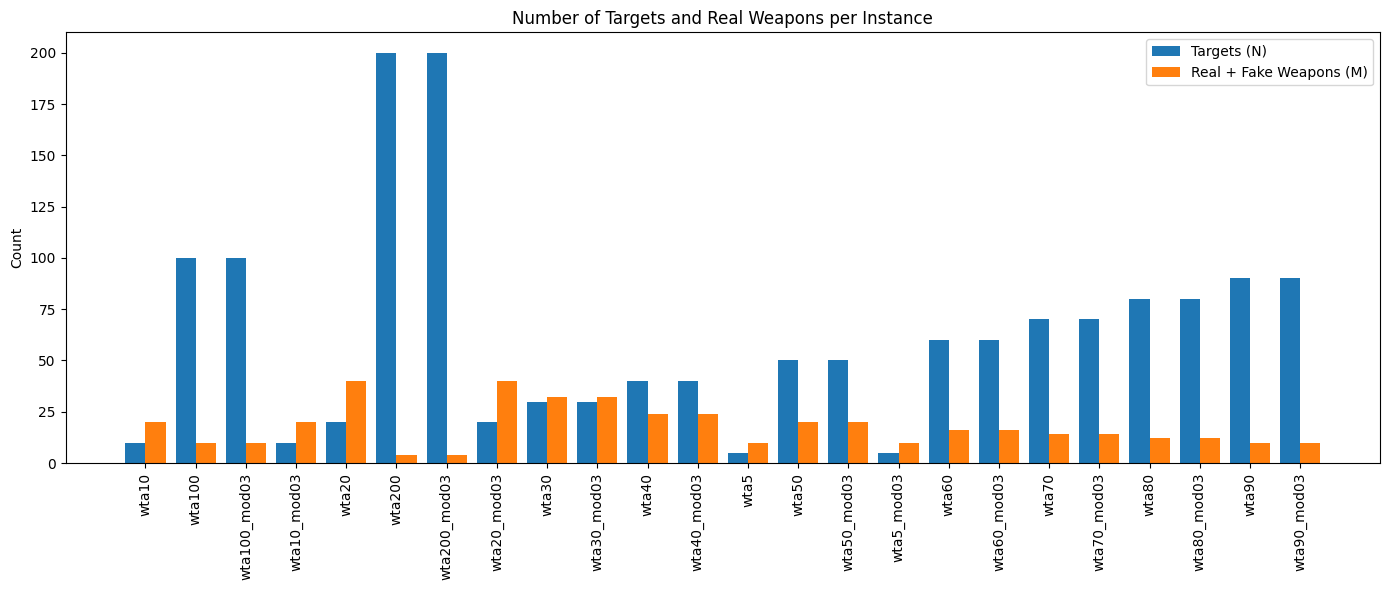

In [ ]:
import os
import matplotlib.pyplot as plt

input_dir = "./instancje_shrink"

instance_names = []
target_counts = []
weapon_counts = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".dat"):
        filepath = os.path.join(input_dir, filename)
        with open(filepath, "r") as f:
            lines = f.readlines()
        N = int(lines[0])
        M_real = int(lines[1])
        M_fake = M_real
        M = M_real + M_fake

        instance_names.append(filename.replace("sonuc_bayir_", "").replace(".dat", ""))
        target_counts.append(N)
        weapon_counts.append(M)

x = range(len(instance_names))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], target_counts, width=width, label="Targets (N)")
plt.bar([i + width/2 for i in x], weapon_counts, width=width, label="Real + Fake Weapons (M)")

plt.xticks(x, instance_names, rotation=90)
plt.ylabel("Count")
plt.title("Number of Targets and Real Weapons per Instance")
plt.legend()
plt.tight_layout()
plt.show()

# scenario 1

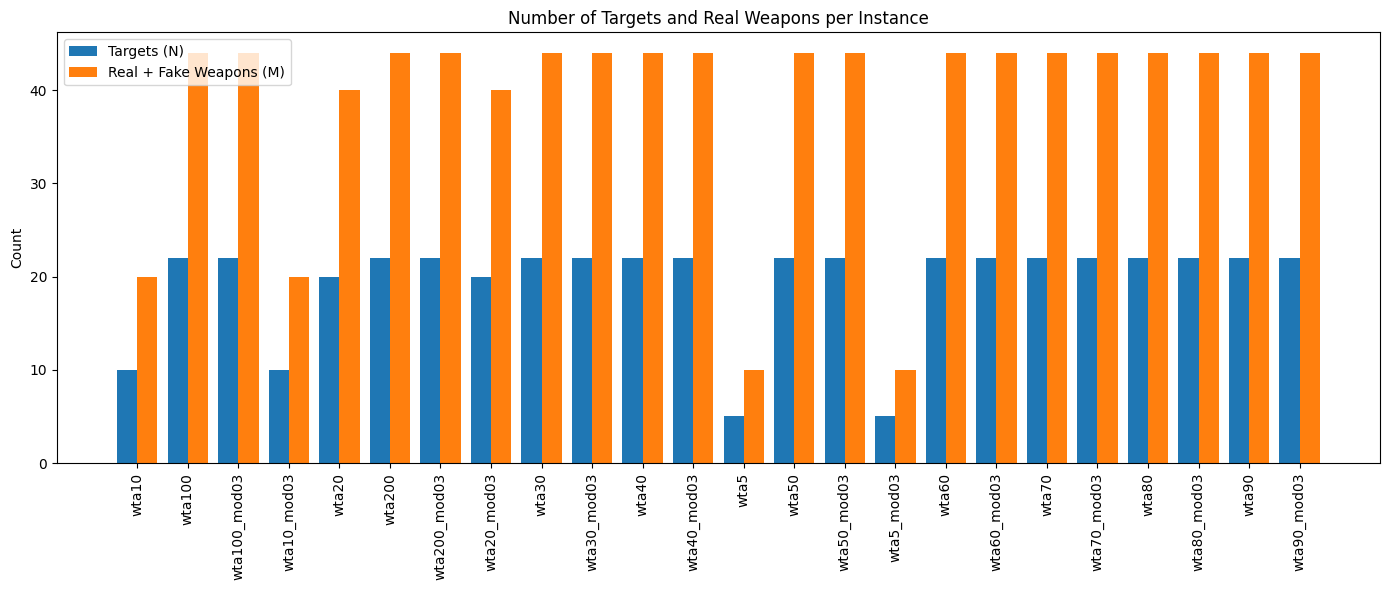

In [ ]:
import os
import matplotlib.pyplot as plt

input_dir = "./instancje_shrink"

instance_names = []
target_counts = []
weapon_counts = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".dat"):
        filepath = os.path.join(input_dir, filename)
        with open(filepath, "r") as f:
            lines = f.readlines()
        N = int(lines[0])
        M_real = int(lines[1])
        M_fake = M_real
        M = M_real + M_fake

        instance_names.append(filename.replace("sonuc_bayir_", "").replace(".dat", ""))
        target_counts.append(N)
        weapon_counts.append(M)

x = range(len(instance_names))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], target_counts, width=width, label="Targets (N)")
plt.bar([i + width/2 for i in x], weapon_counts, width=width, label="Real + Fake Weapons (M)")

plt.xticks(x, instance_names, rotation=90)
plt.ylabel("Count")
plt.title("Number of Targets and Real Weapons per Instance")
plt.legend()
plt.tight_layout()
plt.show()

# scenario 2

# 3) Implementation of P1 problem (Karaskal)

In [ ]:
def p1_solution(lines):
  N = int(lines[0])
  M_real = int(lines[1])

  target_value = ast.literal_eval(lines[2])
  pk_real = np.array(ast.literal_eval("".join(lines[3:])))

  # P1
  # h function assuptions
  max_a = max(target_value)
  h = [0.60 * a / max_a for a in target_value]

  # fake weapons
  M_fake = M_real
  M = M_real + M_fake
  fake_pk = np.full((M_fake, N), 0.999999)
  pk = np.vstack([pk_real, fake_pk])

  model = Model(name=f"WTA_{filename}")
  model.context.solver.agent = "cplex"

  # creation of x
  x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]

  # lhs rhs inequality
  for j in range(N):
      lhs = model.sum(x[i][j] * math.log(1 - pk[i][j]) for i in range(M))
      rhs = math.log(1 - h[j])
      model.add_constraint(lhs <= rhs)

  for i in range(M_real):
      model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

  fake_weapon_usage = model.sum(x[i][j] for i in range(M_real, M) for j in range(N))
  model.minimize(fake_weapon_usage)

  return model, x, pk, h

## 3.1) P1 - Time comparison

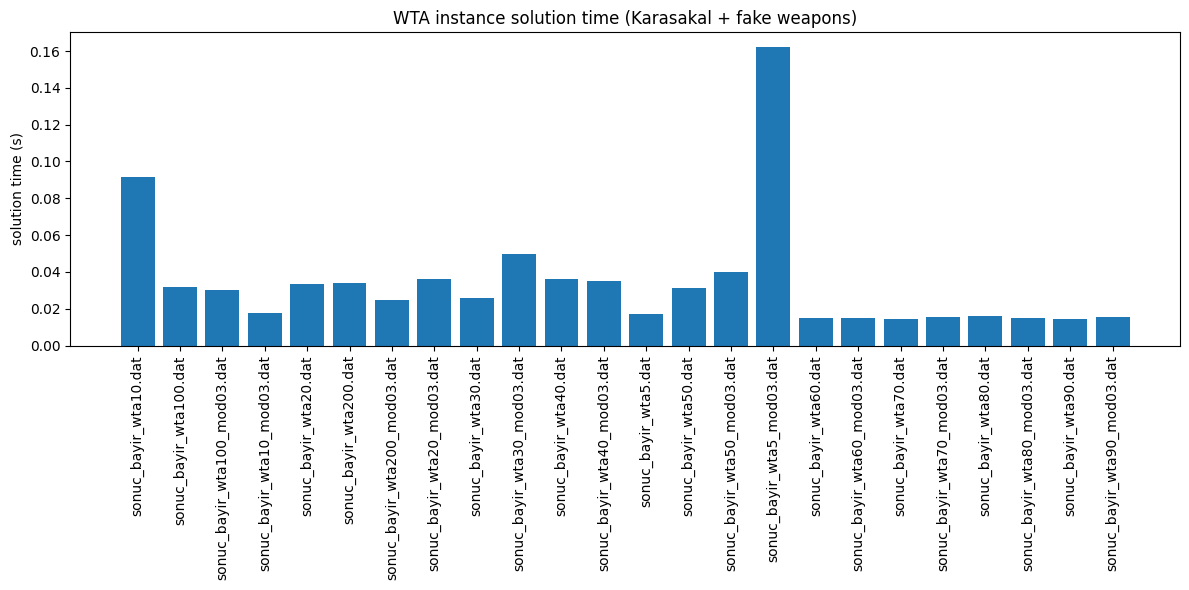

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

input_dir = "/content/instancje_shrink"
times = []
instance_names = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".dat"):
        filepath = os.path.join(input_dir, filename)

        # read
        with open(filepath, "r") as f:
            lines = f.readlines()

        model,_,_,_ = p1_solution(lines)

        # Compute time
        start = time.time()
        solution = model.solve(log_output=False)
        end = time.time()

        duration = end - start
        times.append(duration)
        instance_names.append(filename)

# bar plot
plt.figure(figsize=(12, 6))
plt.bar(instance_names, times)
plt.xticks(rotation=90)
plt.ylabel("solution time (s)")
plt.title("WTA instance solution time (Karasakal + fake weapons)")
plt.tight_layout()
plt.show()

## 3.2) P1 metrics: expected survival value, per-target attack (scenario 1)

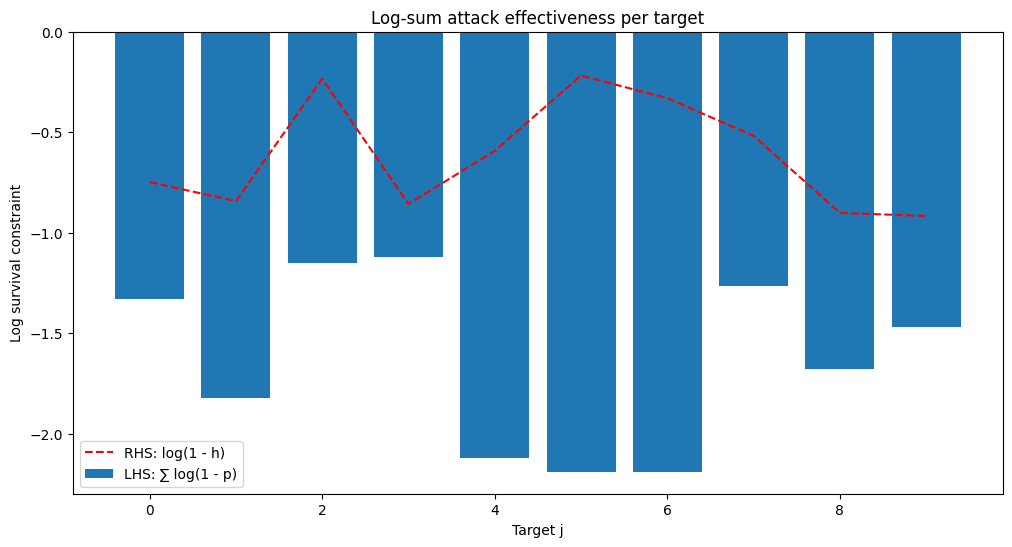


=== Instancja: sonuc_bayir_wta10.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 156.1073


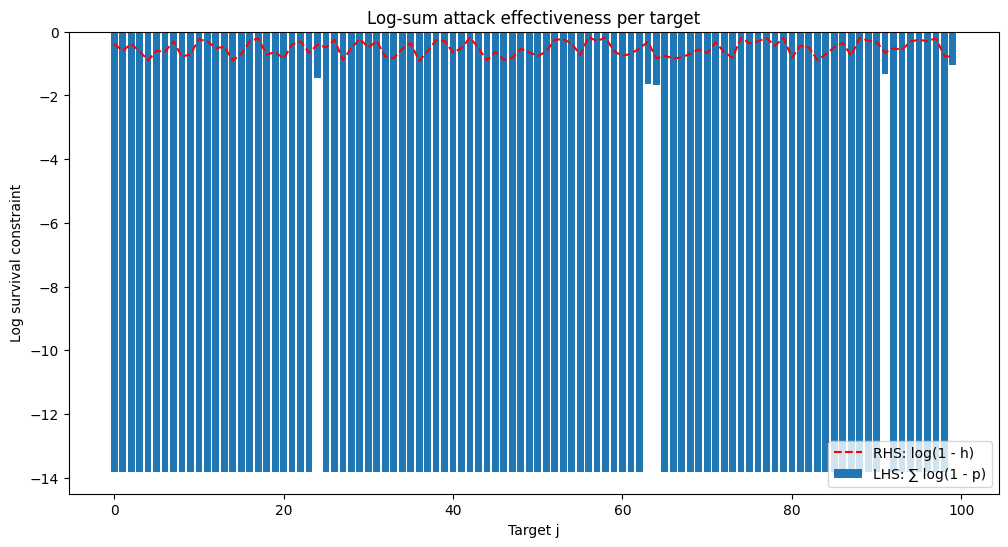


=== Instancja: sonuc_bayir_wta100.dat ===
Fake weapons used: 95.0
Expected survival (real weapons only): 6305.5227


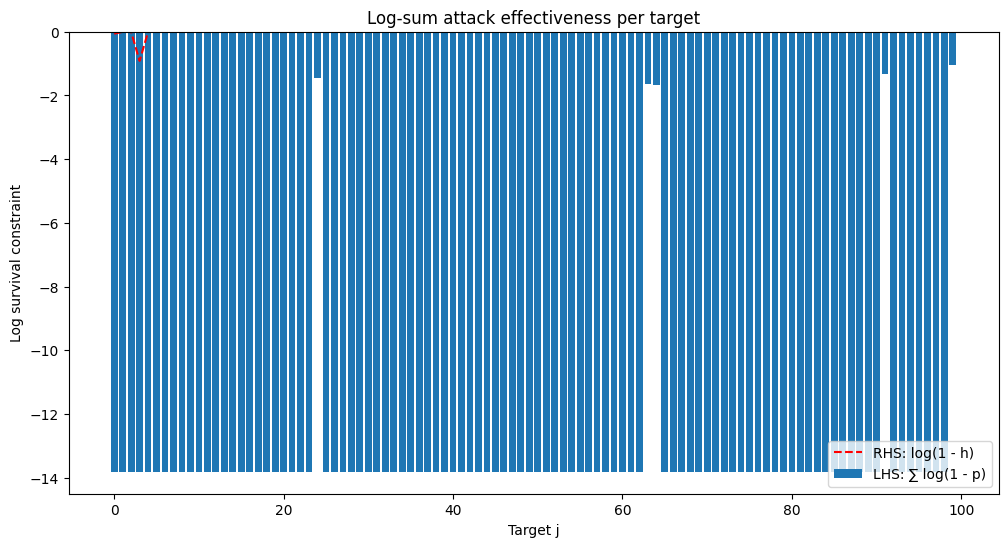


=== Instancja: sonuc_bayir_wta100_mod03.dat ===
Fake weapons used: 95.0
Expected survival (real weapons only): 17176.5227


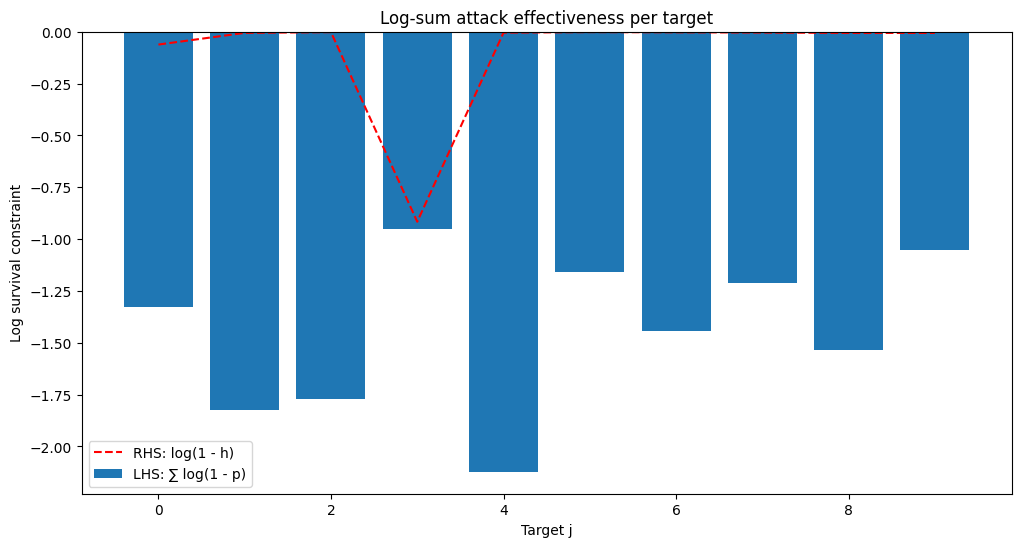


=== Instancja: sonuc_bayir_wta10_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 4250.9735


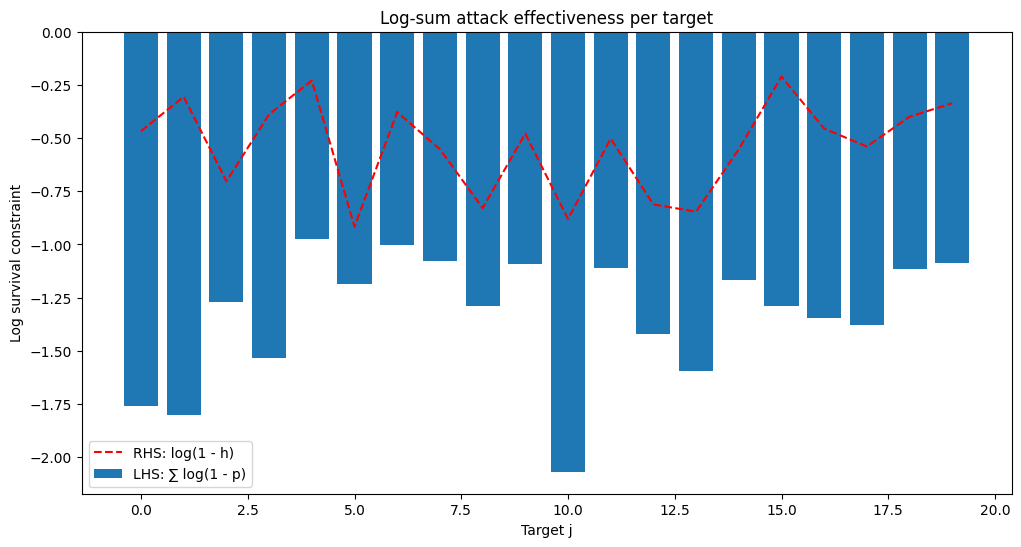


=== Instancja: sonuc_bayir_wta20.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 295.9768


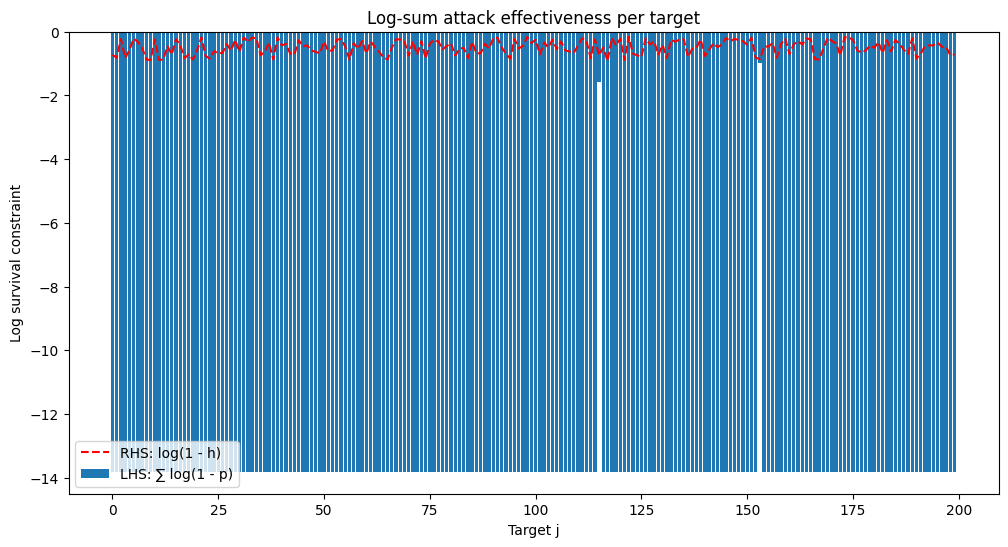


=== Instancja: sonuc_bayir_wta200.dat ===
Fake weapons used: 198.0
Expected survival (real weapons only): 12331.8941


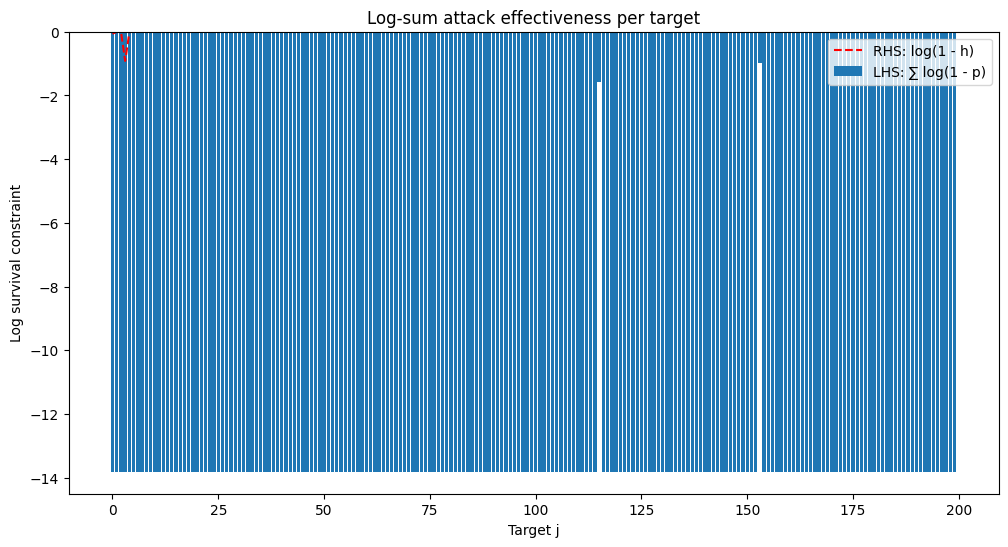


=== Instancja: sonuc_bayir_wta200_mod03.dat ===
Fake weapons used: 198.0
Expected survival (real weapons only): 23151.8941


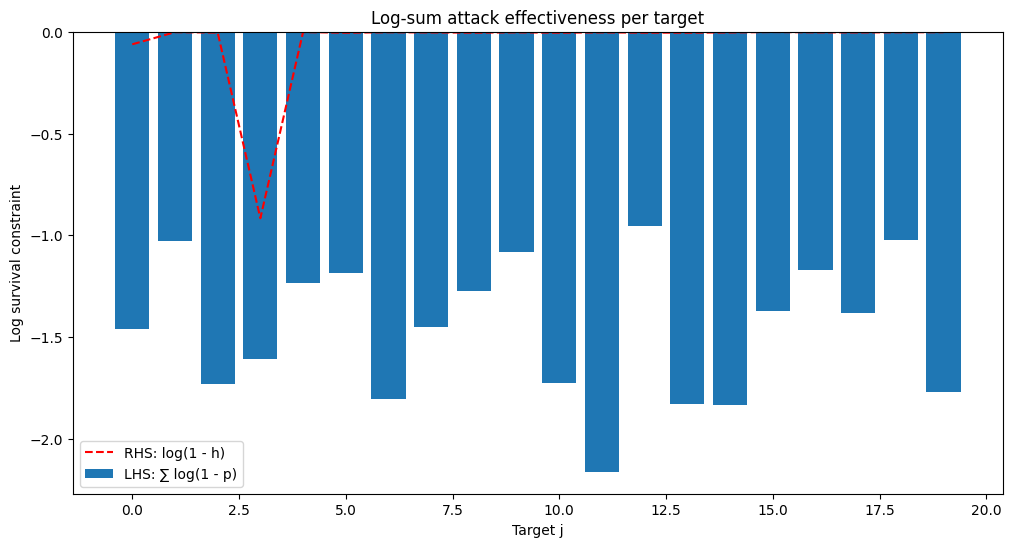


=== Instancja: sonuc_bayir_wta20_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 2482.1498


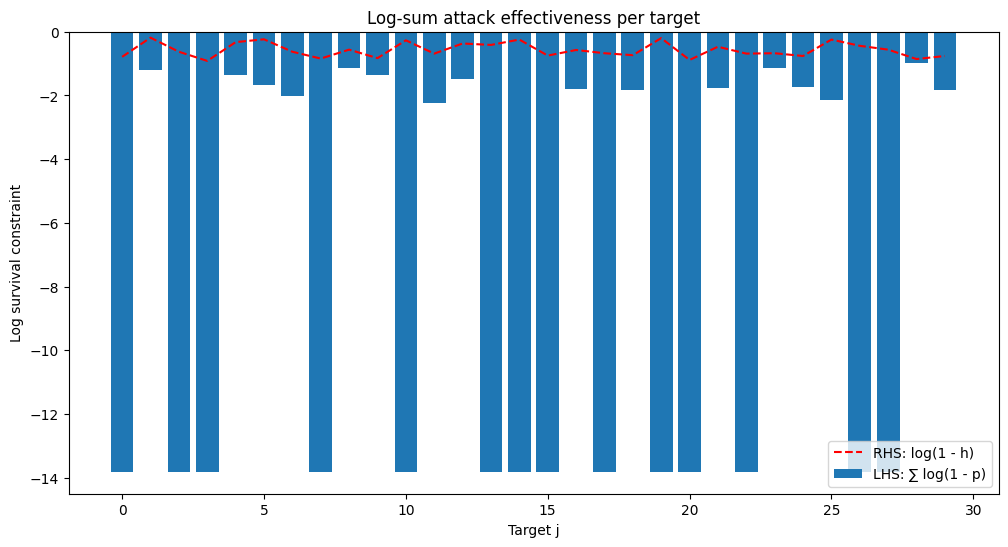


=== Instancja: sonuc_bayir_wta30.dat ===
Fake weapons used: 14.0
Expected survival (real weapons only): 1233.3653


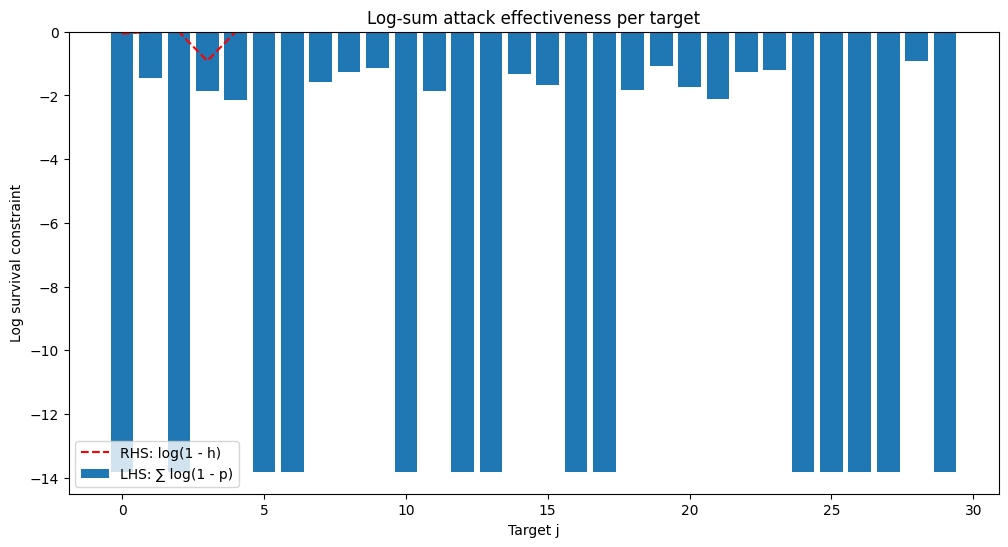


=== Instancja: sonuc_bayir_wta30_mod03.dat ===
Fake weapons used: 14.0
Expected survival (real weapons only): 3652.2441


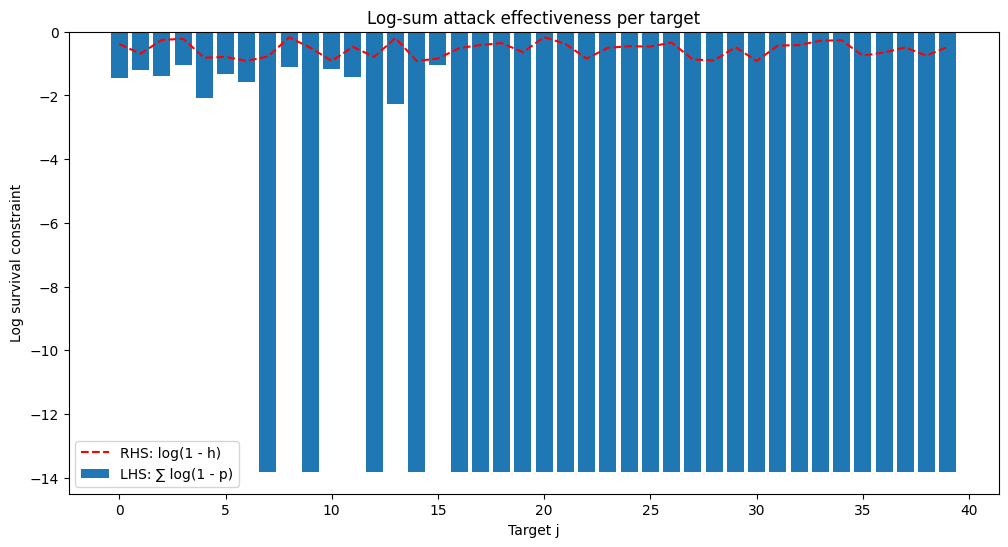


=== Instancja: sonuc_bayir_wta40.dat ===
Fake weapons used: 28.0
Expected survival (real weapons only): 2158.8530


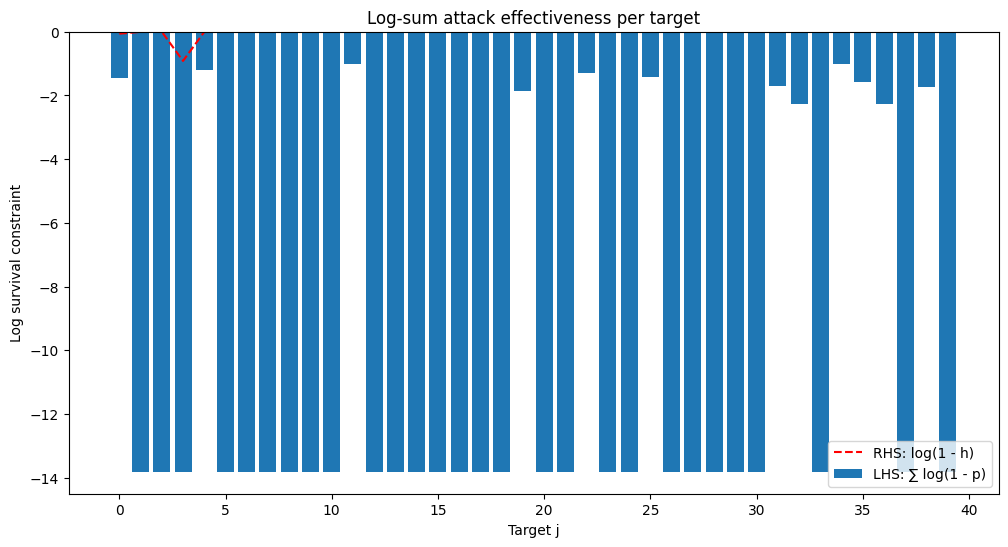


=== Instancja: sonuc_bayir_wta40_mod03.dat ===
Fake weapons used: 28.0
Expected survival (real weapons only): 12278.5229


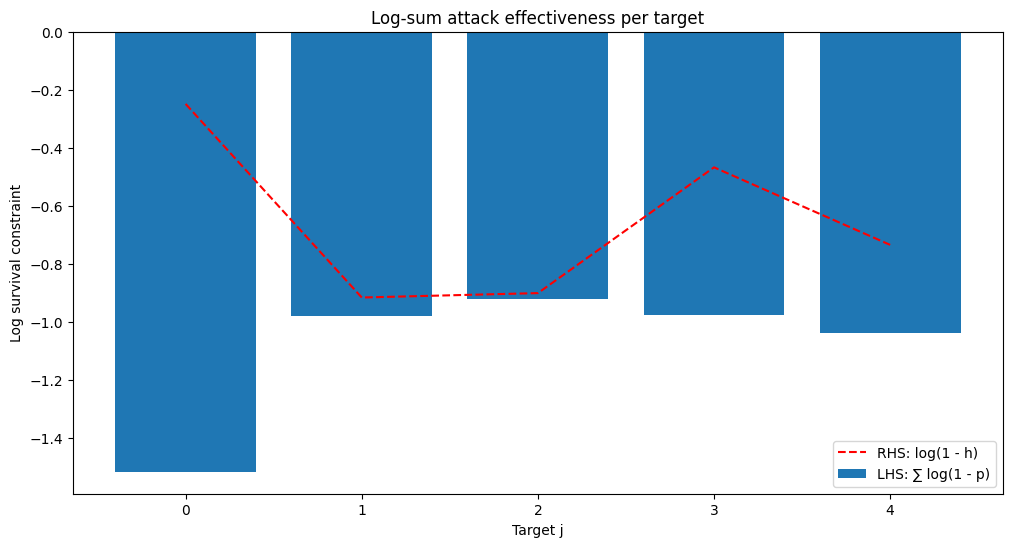


=== Instancja: sonuc_bayir_wta5.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 136.3652


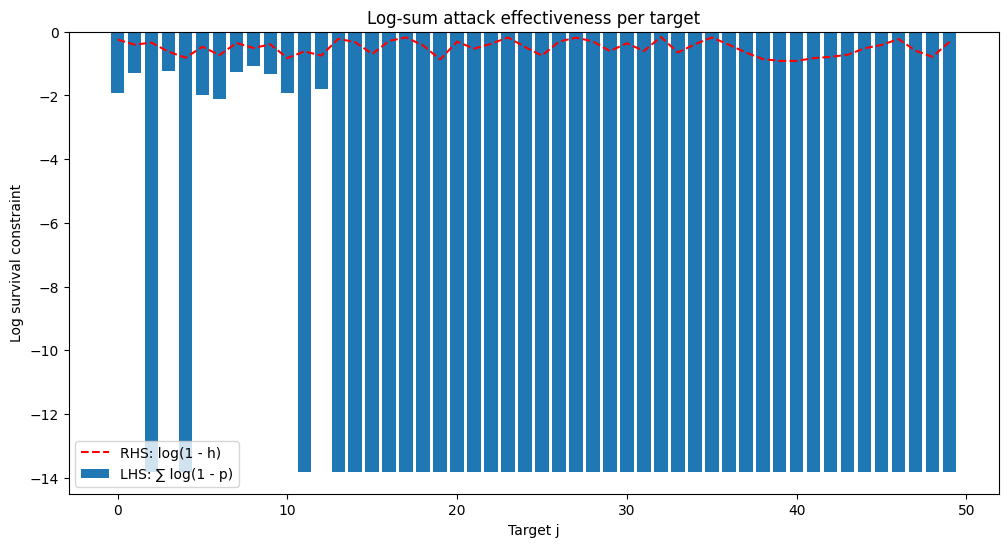


=== Instancja: sonuc_bayir_wta50.dat ===
Fake weapons used: 40.0
Expected survival (real weapons only): 2642.6795


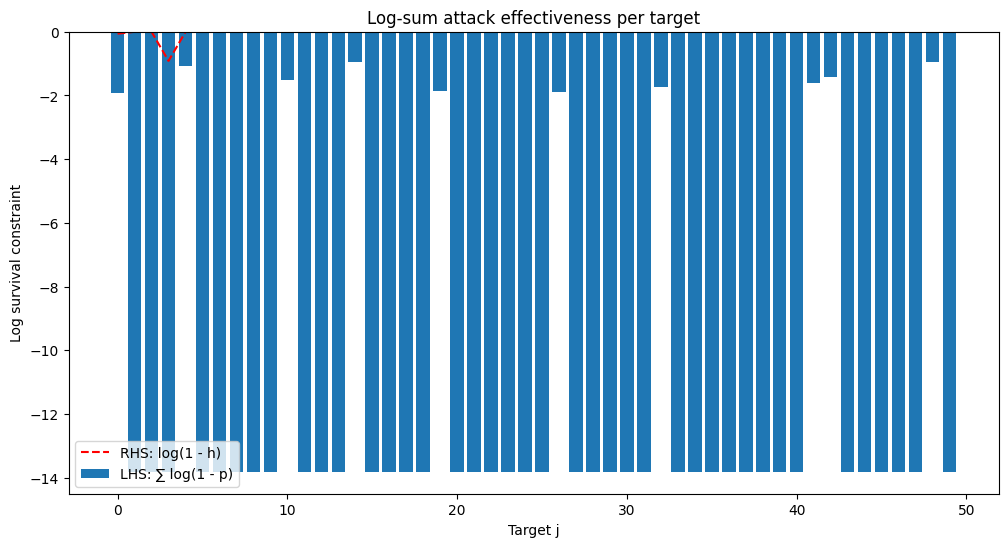


=== Instancja: sonuc_bayir_wta50_mod03.dat ===
Fake weapons used: 40.0
Expected survival (real weapons only): 12703.4987


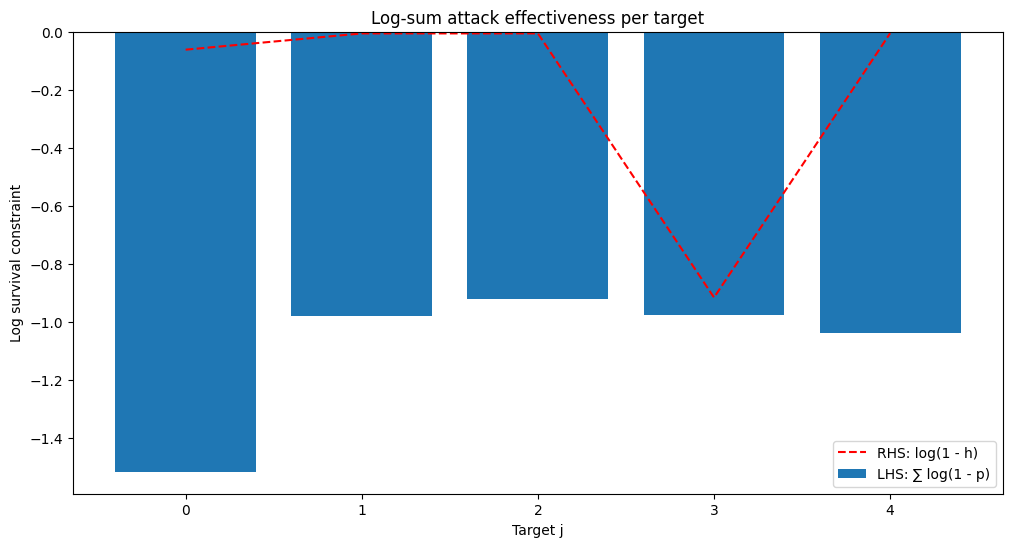


=== Instancja: sonuc_bayir_wta5_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 4089.9003


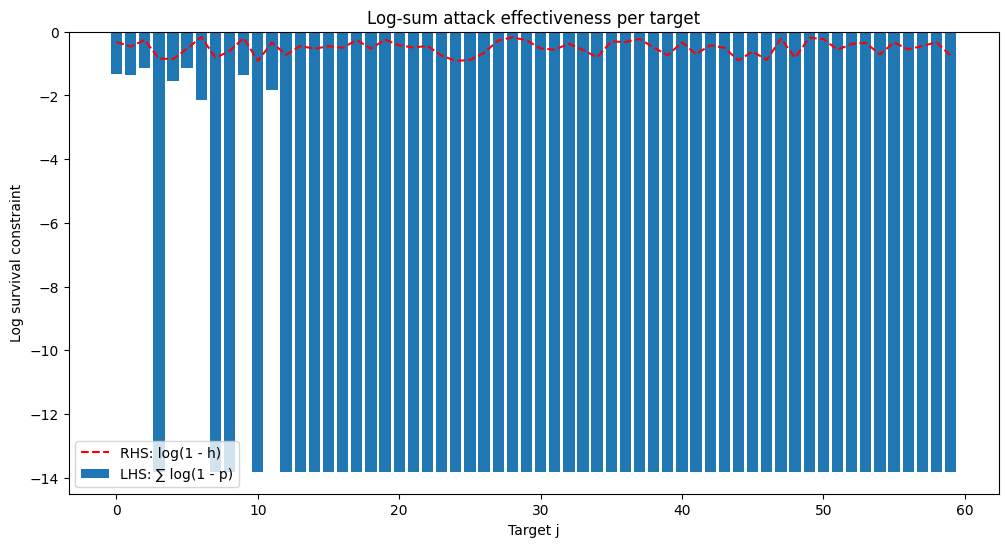


=== Instancja: sonuc_bayir_wta60.dat ===
Fake weapons used: 52.0
Expected survival (real weapons only): 3528.3070


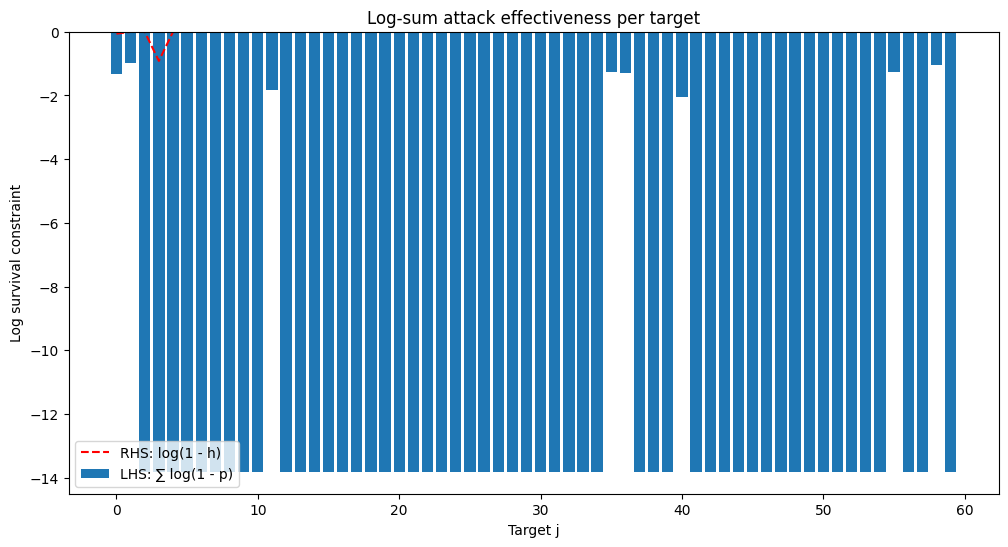


=== Instancja: sonuc_bayir_wta60_mod03.dat ===
Fake weapons used: 52.0
Expected survival (real weapons only): 13715.7480


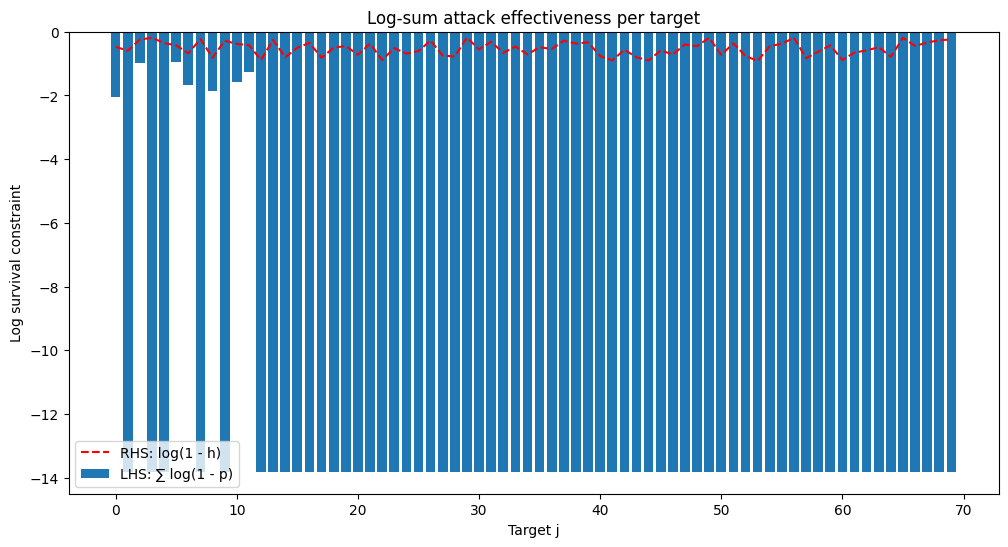


=== Instancja: sonuc_bayir_wta70.dat ===
Fake weapons used: 63.0
Expected survival (real weapons only): 4290.2999


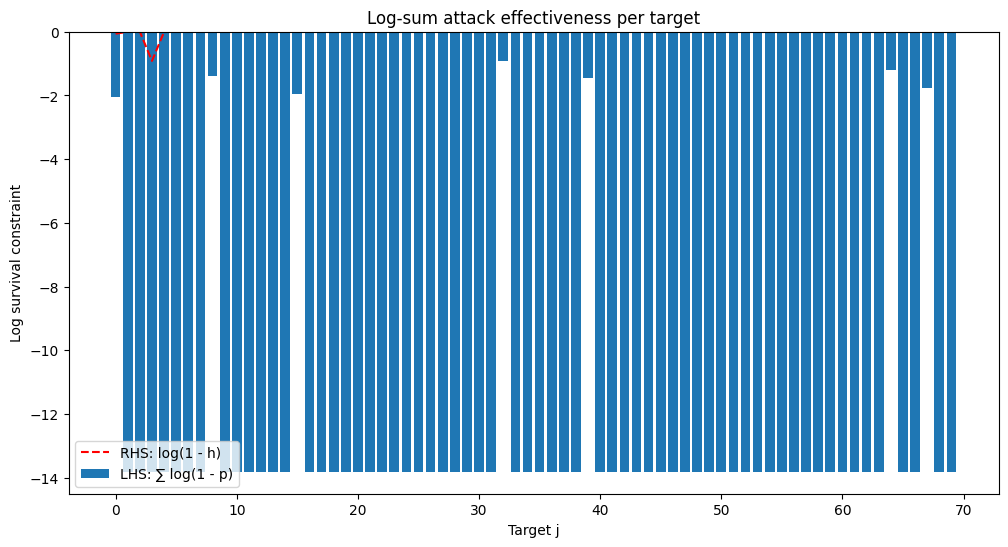


=== Instancja: sonuc_bayir_wta70_mod03.dat ===
Fake weapons used: 63.0
Expected survival (real weapons only): 14353.6597


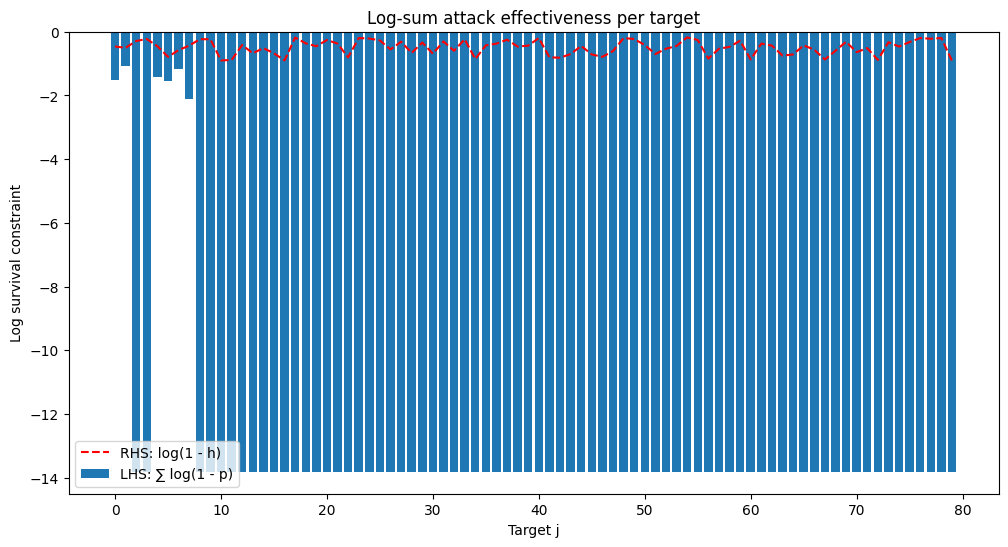


=== Instancja: sonuc_bayir_wta80.dat ===
Fake weapons used: 74.0
Expected survival (real weapons only): 4698.5787


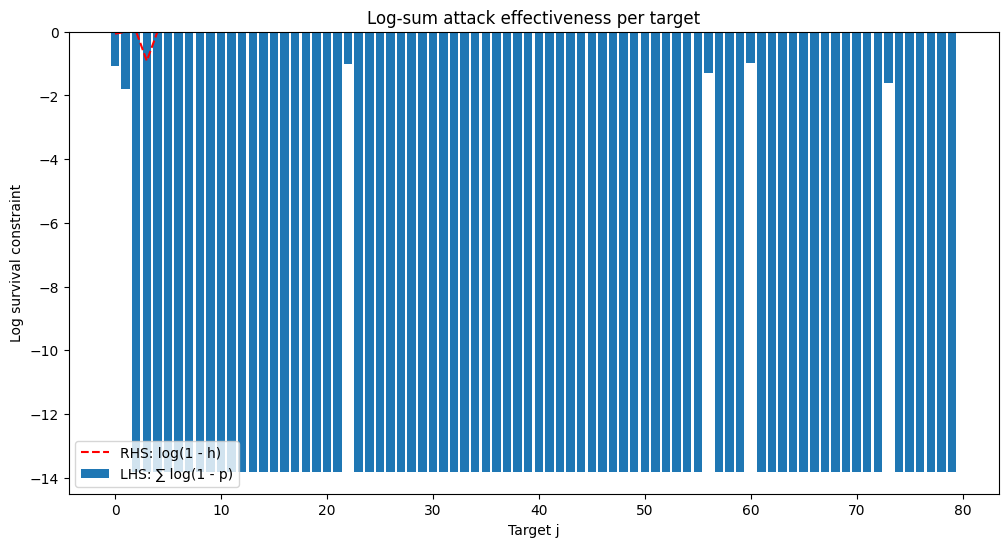


=== Instancja: sonuc_bayir_wta80_mod03.dat ===
Fake weapons used: 74.0
Expected survival (real weapons only): 14971.4425


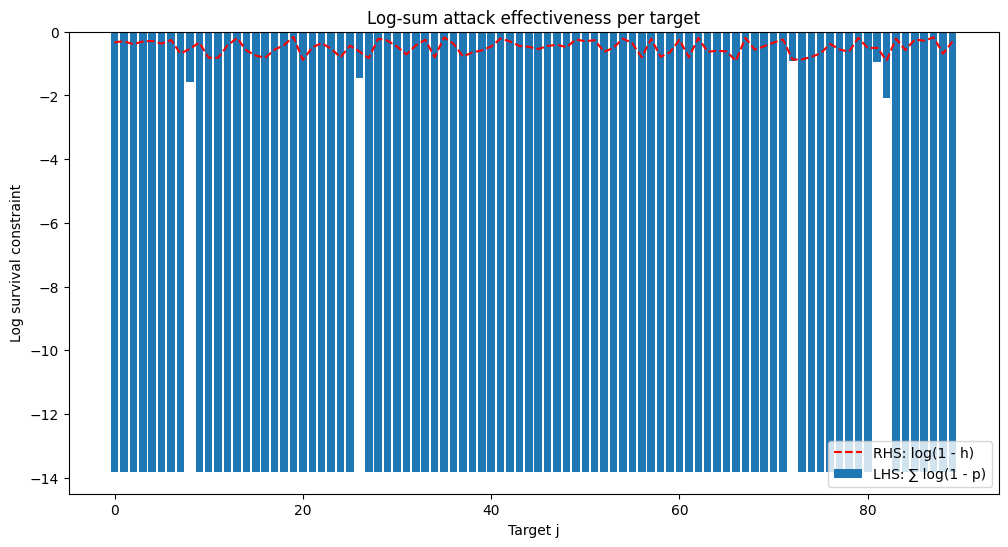


=== Instancja: sonuc_bayir_wta90.dat ===
Fake weapons used: 85.0
Expected survival (real weapons only): 5291.3227


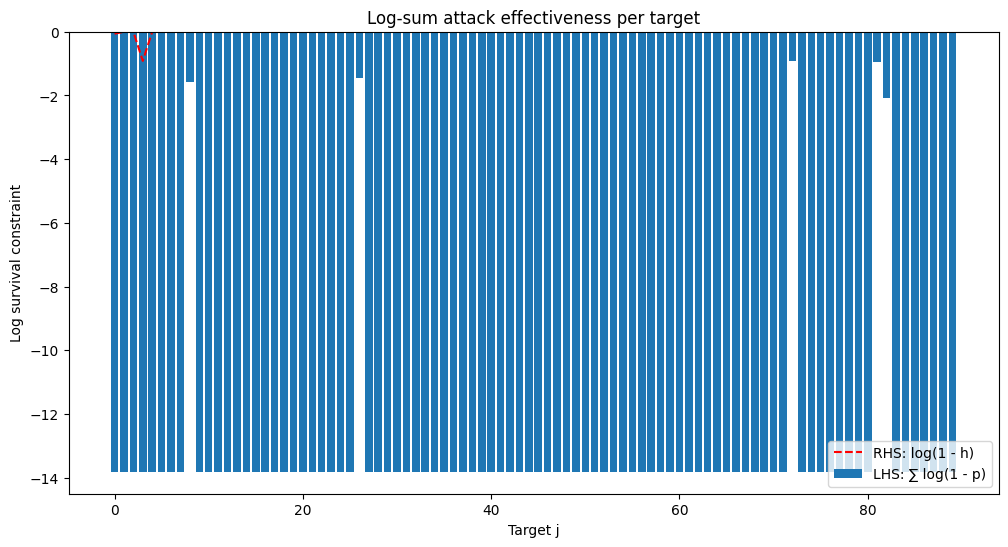


=== Instancja: sonuc_bayir_wta90_mod03.dat ===
Fake weapons used: 85.0
Expected survival (real weapons only): 16200.3227


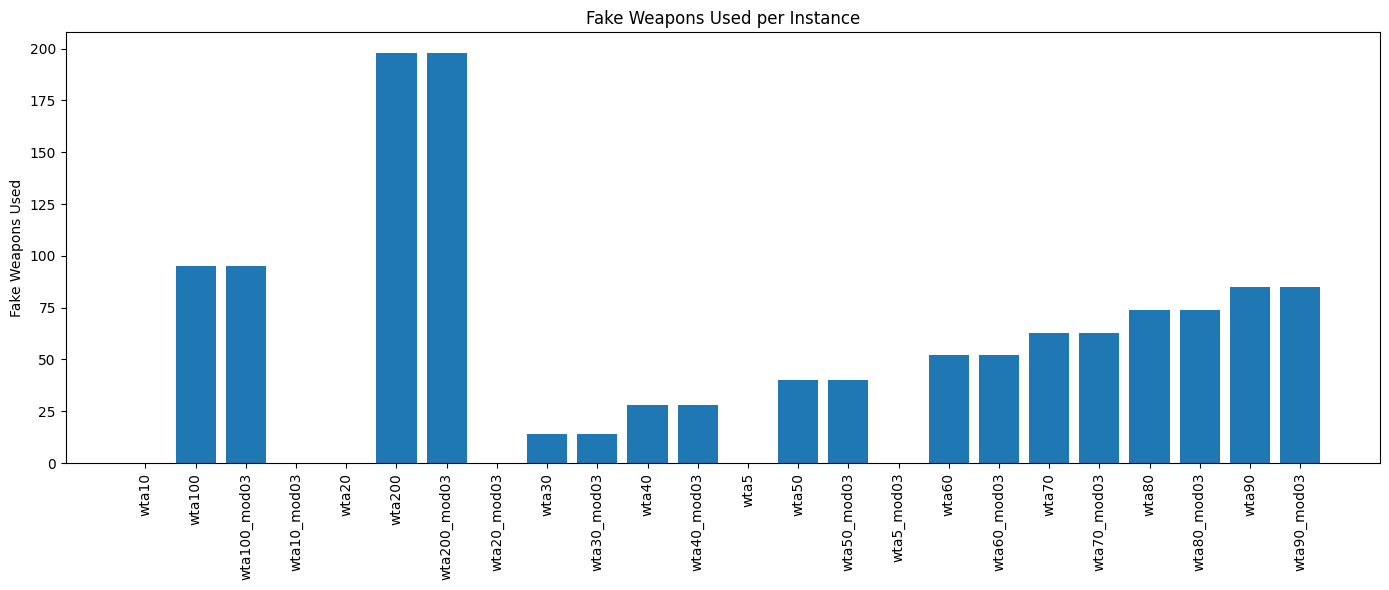

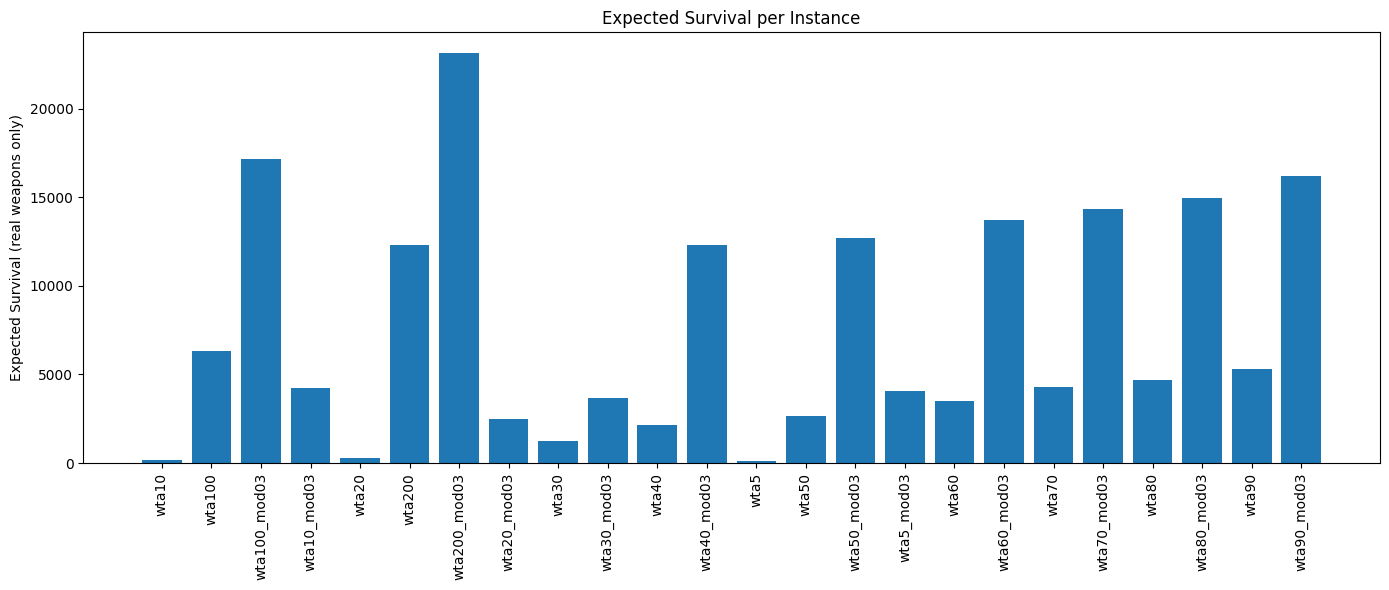

In [ ]:
input_dir = "/content/instancje_shrink"

fake_weapons_data = []
expected_survival_data = []
instance_labels = []

for filename in sorted(os.listdir(input_dir)):
    if not filename.endswith(".dat"):
        continue

    filepath = os.path.join(input_dir, filename)
    with open(filepath, "r") as f:
        lines = f.readlines()

    model, x, pk, h = p1_solution(lines)
    N = int(lines[0])
    M_real = int(lines[1])
    M_fake = M_real
    M = M_fake + M_real
    target_value = ast.literal_eval(lines[2])

    solution = model.solve(log_output=False) # solve

    log_hits = []
    rhs_vals = []

    for j in range(N):
        lhs = 0.0
        for i in range(M):
            if x[i][j].solution_value > 0.5:
                lhs += math.log(1 - pk[i][j])
        rhs = math.log(1 - h[j])
        log_hits.append(lhs)
        rhs_vals.append(rhs)

    plt.figure(figsize=(12, 6))
    plt.bar(range(N), log_hits, label="LHS: ∑ log(1 - p)")
    plt.plot(range(N), rhs_vals, 'r--', label="RHS: log(1 - h)")
    plt.xlabel("Target j")
    plt.ylabel("Log survival constraint")
    plt.title("Log-sum attack effectiveness per target")
    plt.legend()
    plt.show()


    if solution:
        print(f"\n=== Instancja: {filename} ===")
        print(f"Fake weapons used: {solution.objective_value}")

        expected_survival = 0
        for j in range(N):
            survival_prob = 1.0
            for i in range(M_real):
                if x[i][j].solution_value > 0.5:
                    survival_prob *= (1 - pk[i][j])
            expected_survival += target_value[j] * survival_prob

        print(f"Expected survival (real weapons only): {expected_survival:.4f}")

        # chart data
        instance_labels.append(filename.replace("sonuc_bayir_", "").replace(".dat", ""))
        fake_weapons_data.append(solution.objective_value)
        expected_survival_data.append(expected_survival)

    else:
        print(f"{filename}: brak rozwiązania.")

if instance_labels:
    plt.figure(figsize=(14, 6))
    plt.bar(instance_labels, fake_weapons_data)
    plt.xticks(rotation=90)
    plt.ylabel("Fake Weapons Used")
    plt.title("Fake Weapons Used per Instance")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.bar(instance_labels, expected_survival_data)
    plt.xticks(rotation=90)
    plt.ylabel("Expected Survival (real weapons only)")
    plt.title("Expected Survival per Instance")
    plt.tight_layout()
    plt.show()

## 3.3) P1 metrics: expected survival value, per-target attack (scenario 2)


=== Instancja: sonuc_bayir_wta10.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 156.1073

=== Instancja: sonuc_bayir_wta100.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 401.2285

=== Instancja: sonuc_bayir_wta100_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 519.8642

=== Instancja: sonuc_bayir_wta10_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 4250.9735

=== Instancja: sonuc_bayir_wta20.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 295.9768

=== Instancja: sonuc_bayir_wta200.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 378.5168

=== Instancja: sonuc_bayir_wta200_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 520.7792

=== Instancja: sonuc_bayir_wta20_mod03.dat ===
Fake weapons used: 0.0
Expected survival (real weapons only): 2482.1498

=== Instancja: sonuc_bayir_wta30.dat ===
Fake weapons used: 0.0
E

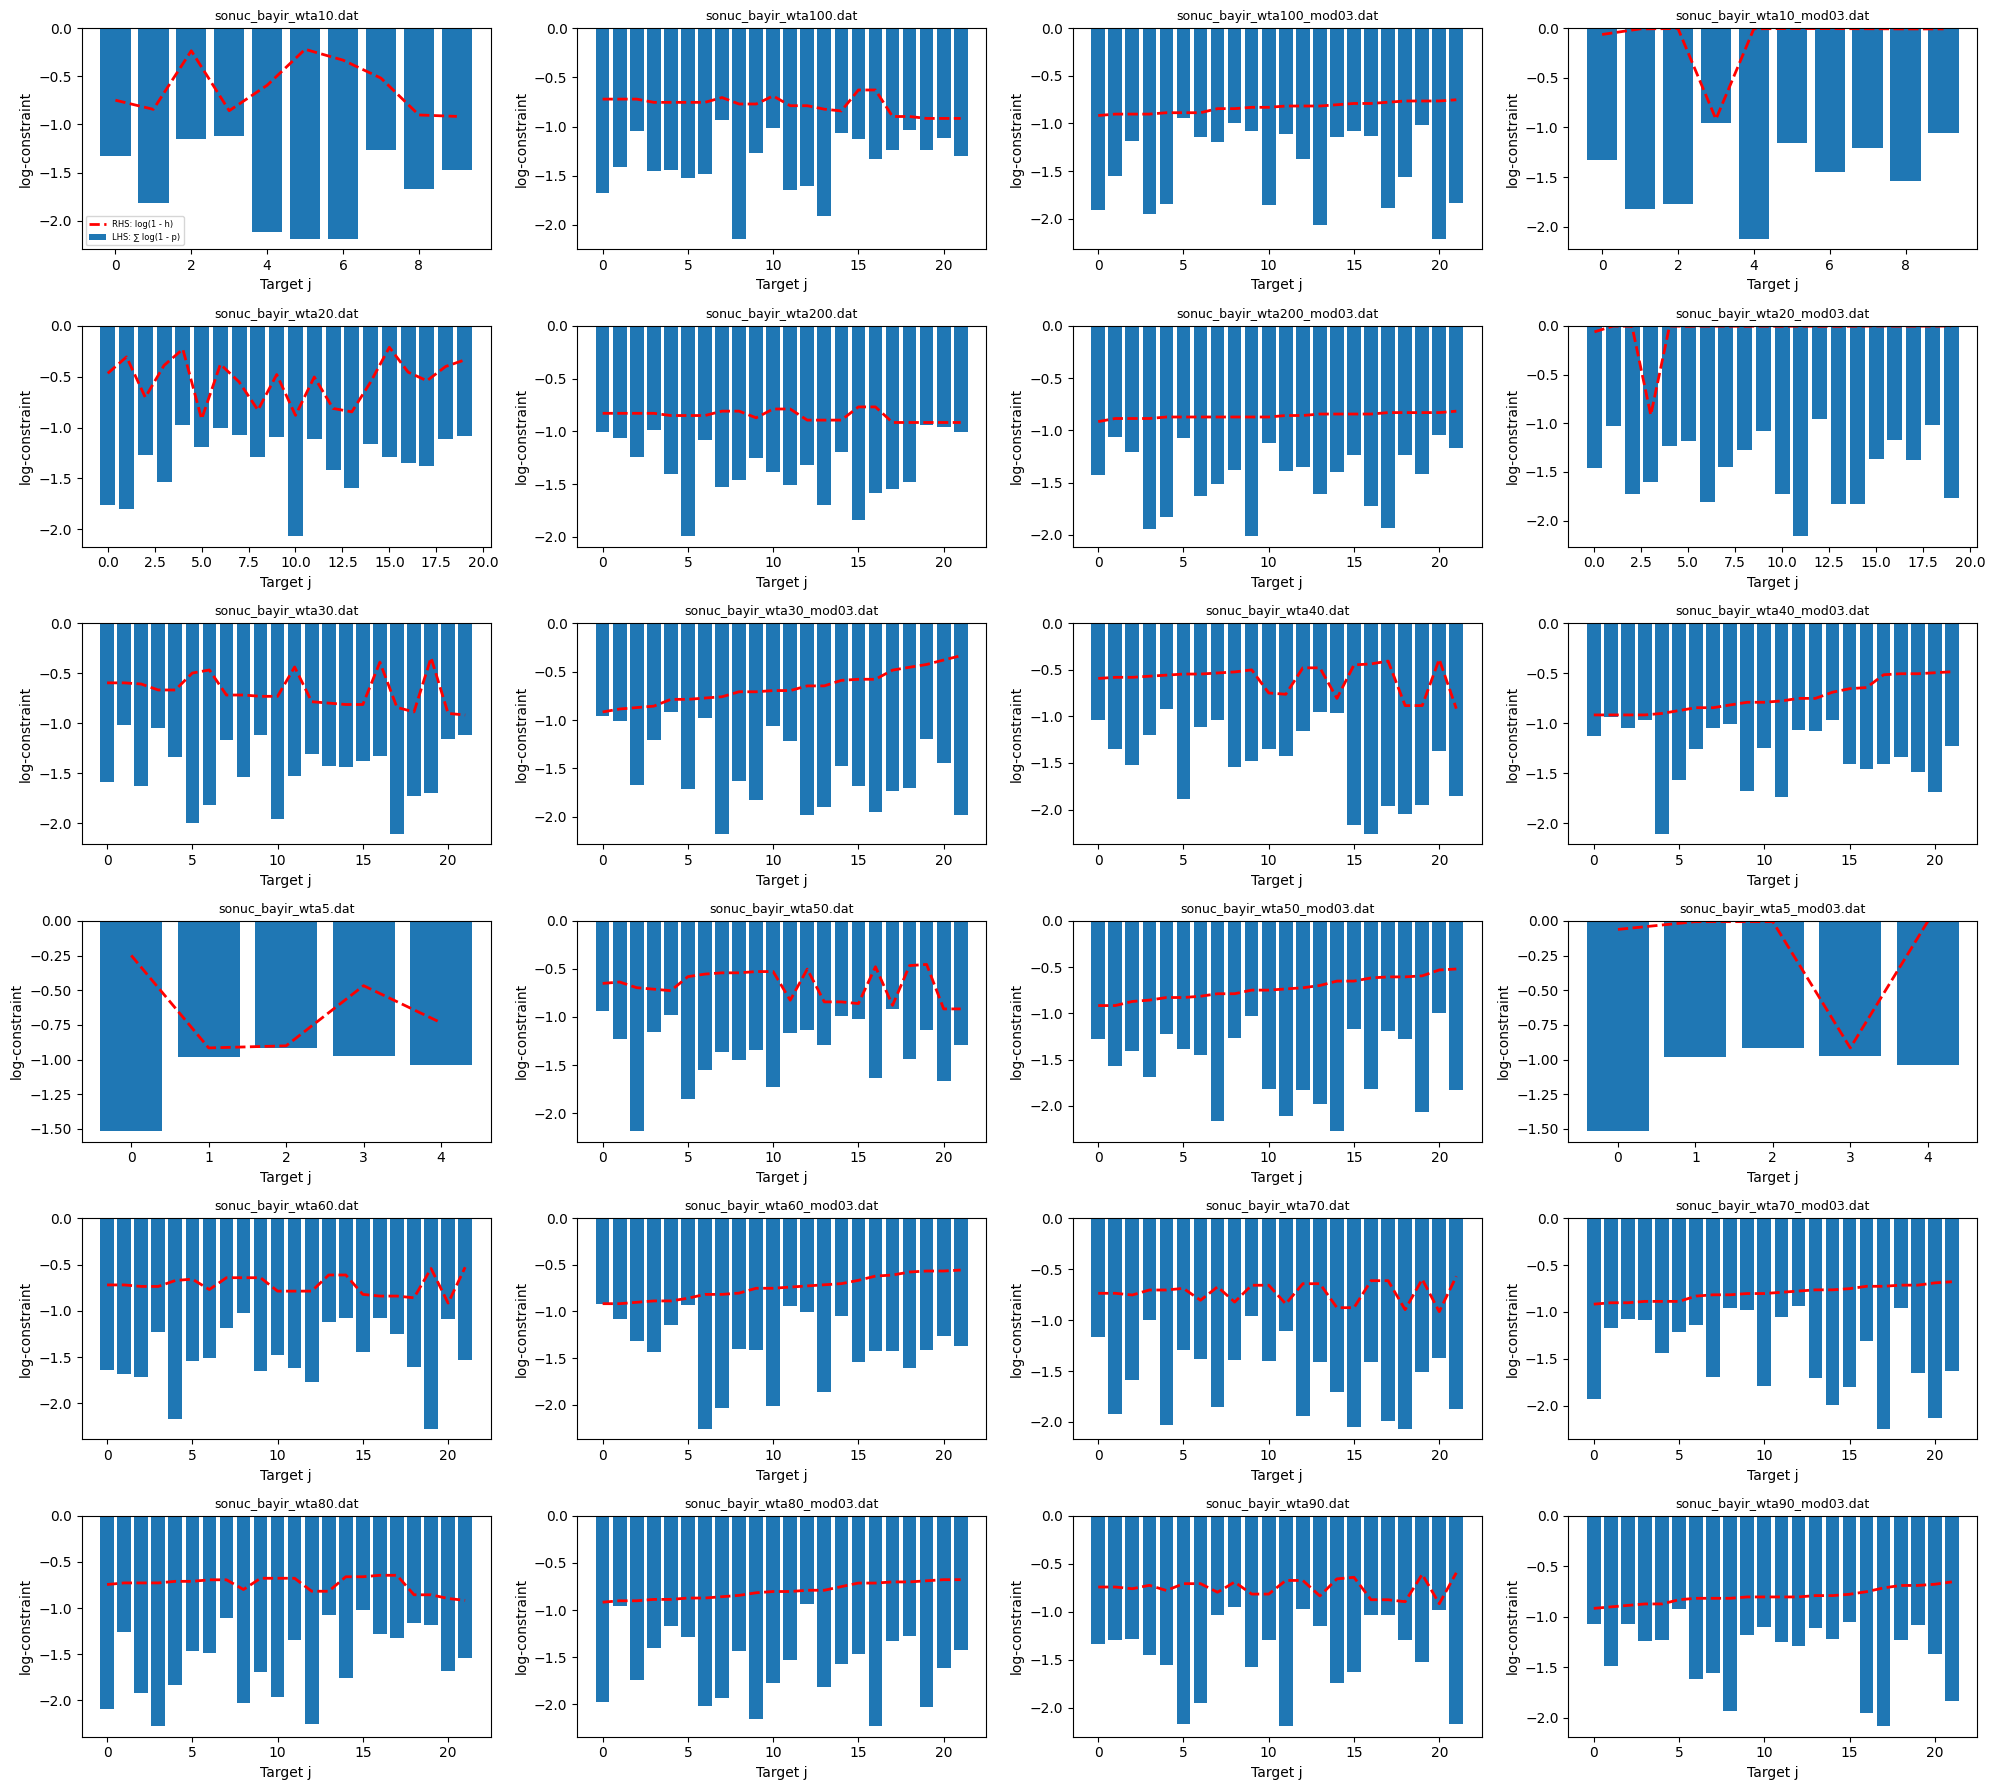

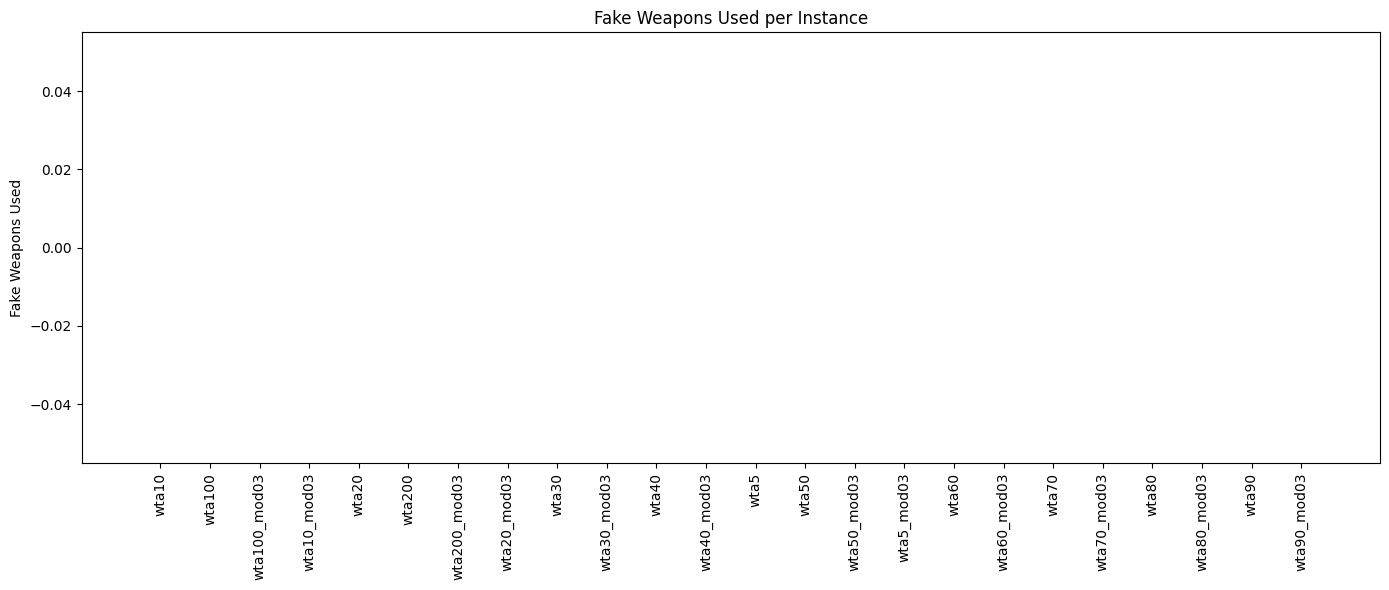

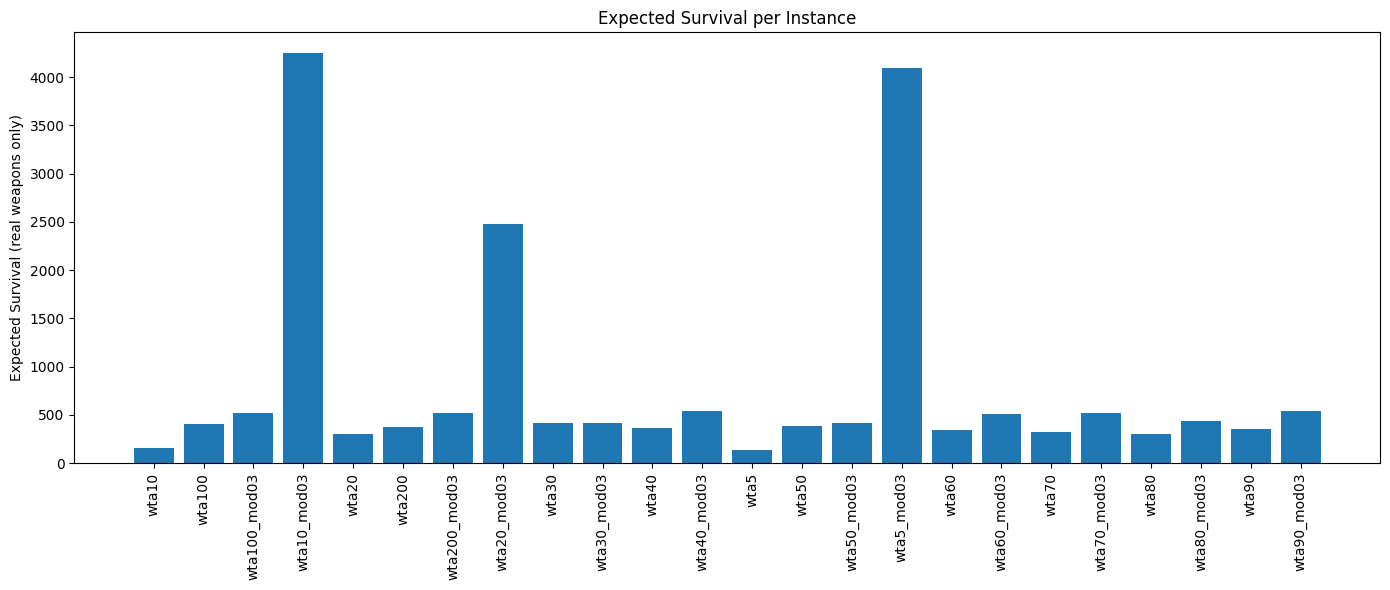

In [ ]:
input_dir = "/content/instancje_shrink"

fake_weapons_data = []
expected_survival_data = []
instance_labels = []

files = sorted([f for f in os.listdir(input_dir) if f.endswith(".dat")])

rows, cols = 6, 4  # chart 6x4
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3))

for idx, filename in enumerate(files):
    filepath = os.path.join(input_dir, filename)
    with open(filepath, "r") as f:
        lines = f.readlines()

    model, x, pk, h = p1_solution(lines)
    N = int(lines[0])
    M_real = int(lines[1])
    M = M_real * 2
    target_value = ast.literal_eval(lines[2])

    model.solve(log_output=False)

    log_hits = []
    rhs_vals = []

    for j in range(N):
        lhs = 0.0
        for i in range(M):
            if x[i][j].solution_value > 0.5:
                lhs += math.log(1 - pk[i][j])
        rhs = math.log(1 - h[j])
        log_hits.append(lhs)
        rhs_vals.append(rhs)

    ax = axes[idx // cols, idx % cols]
    ax.bar(range(N), log_hits, label="LHS: ∑ log(1 - p)")
    ax.plot(range(N), rhs_vals, 'r--', label="RHS: log(1 - h)", linewidth=2)
    ax.set_title(filename, fontsize=9)
    ax.set_xlabel("Target j")
    ax.set_ylabel("log-constraint")

    if idx == 0:
        ax.legend(fontsize=6)


    if solution:
        print(f"\n=== Instancja: {filename} ===")
        print(f"Fake weapons used: {solution.objective_value}")

        expected_survival = 0
        for j in range(N):
            survival_prob = 1.0
            for i in range(M_real):
                if x[i][j].solution_value > 0.5:
                    survival_prob *= (1 - pk[i][j])
            expected_survival += target_value[j] * survival_prob

        print(f"Expected survival (real weapons only): {expected_survival:.4f}")

        # chart data
        instance_labels.append(filename.replace("sonuc_bayir_", "").replace(".dat", ""))
        fake_weapons_data.append(solution.objective_value)
        expected_survival_data.append(expected_survival)

    else:
        print(f"{filename}: brak rozwiązania.")

plt.tight_layout()
plt.show()

if instance_labels:
    plt.figure(figsize=(14, 6))
    plt.bar(instance_labels, fake_weapons_data)
    plt.xticks(rotation=90)
    plt.ylabel("Fake Weapons Used")
    plt.title("Fake Weapons Used per Instance")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.bar(instance_labels, expected_survival_data)
    plt.xticks(rotation=90)
    plt.ylabel("Expected Survival (real weapons only)")
    plt.title("Expected Survival per Instance")
    plt.tight_layout()
    plt.show()

# 4) Impelemtation of P2 problem (Karaskal)

In [ ]:
def p2_solution(lines):
    import math
    import ast
    import numpy as np
    from docplex.mp.model import Model

    N = int(lines[0])
    M_real = int(lines[1])

    target_value = ast.literal_eval(lines[2])
    pk_real = np.array(ast.literal_eval("".join(lines[3:])))

    # count for (h_j)
    max_a = max(target_value)
    h = [0.60 * a / max_a for a in target_value]

    model = Model(name="WTA_P2")
    model.context.solver.agent = "cplex"

    # create x[i][j]
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M_real)]

    # create var e ≥ 0
    e = model.continuous_var(lb=0, name="e")

    # constraints for survival with e
    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk_real[i][j]) for i in range(M_real))
        rhs = math.log(1 - h[j]) - e  # <== change to P1: e
        model.add_constraint(lhs >= rhs, ctname=f"survival_{j}")

    # Each weapon can be use one time
    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    # target function
    model.minimize(e)

    return model, x, pk_real, h, e


## 4.1) time comparison for P2


=== Instancja: sonuc_bayir_wta10.dat ===
Expected survival (real weapons only): 719.0000

=== Instancja: sonuc_bayir_wta100.dat ===
Expected survival (real weapons only): 6579.0000

=== Instancja: sonuc_bayir_wta100_mod03.dat ===
Expected survival (real weapons only): 17450.0000

=== Instancja: sonuc_bayir_wta10_mod03.dat ===
Expected survival (real weapons only): 11539.0000

=== Instancja: sonuc_bayir_wta20.dat ===
Expected survival (real weapons only): 1103.0000

=== Instancja: sonuc_bayir_wta200.dat ===
Expected survival (real weapons only): 12461.0000

=== Instancja: sonuc_bayir_wta200_mod03.dat ===
Expected survival (real weapons only): 23281.0000

=== Instancja: sonuc_bayir_wta20_mod03.dat ===
Expected survival (real weapons only): 12008.0000

=== Instancja: sonuc_bayir_wta30.dat ===
Expected survival (real weapons only): 2089.0000

=== Instancja: sonuc_bayir_wta30_mod03.dat ===
Expected survival (real weapons only): 12900.0000

=== Instancja: sonuc_bayir_wta40.dat ===
Expected 

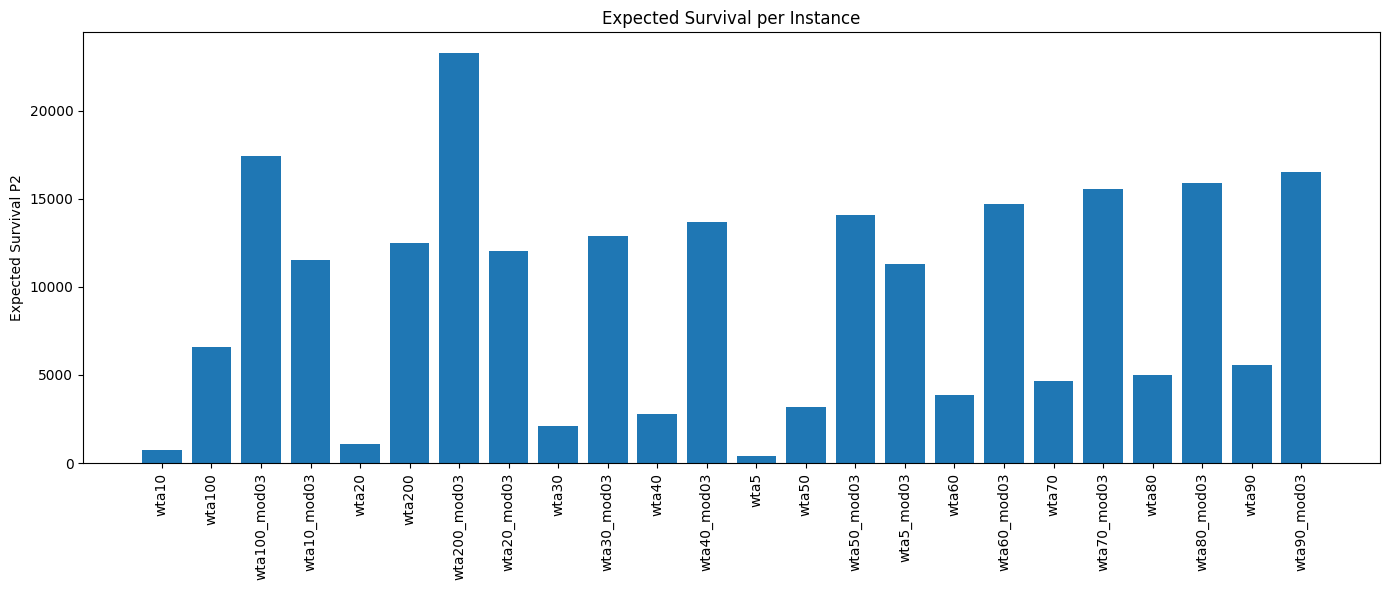

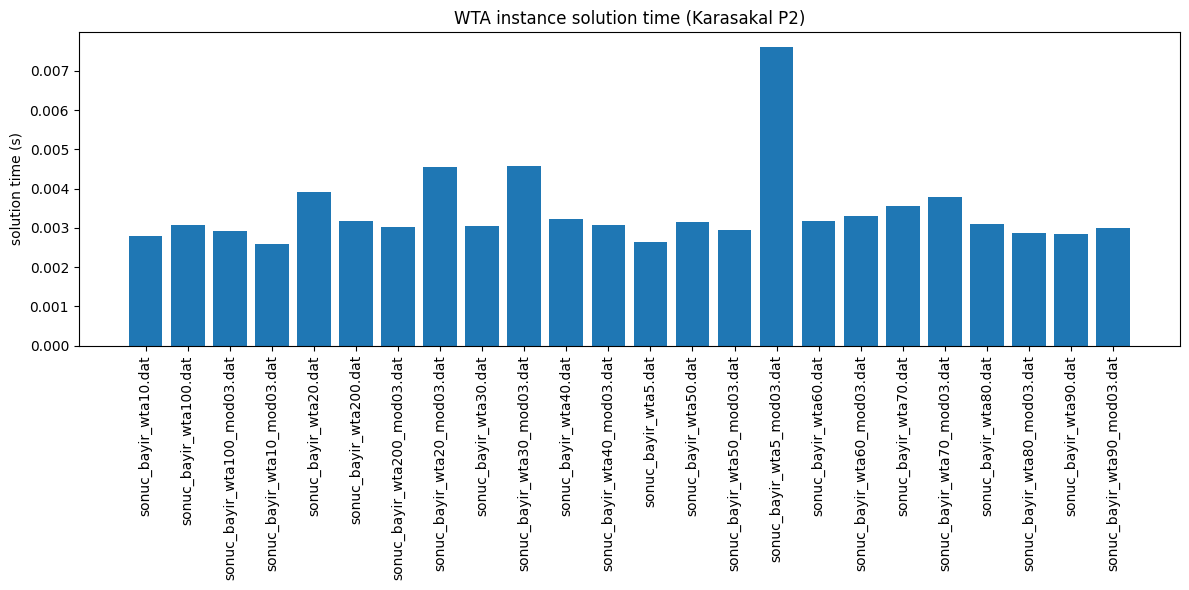

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

input_dir = "/content/instancje_shrink"
times = []
instance_names = []

for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".dat"):
        filepath = os.path.join(input_dir, filename)

        # read
        with open(filepath, "r") as f:
            lines = f.readlines()
        N = int(lines[0])
        M_real = int(lines[1])
        target_value = ast.literal_eval(lines[2])

        model, x, pk_real, h, e = p2_solution(lines)

        # Compute time
        start = time.time()
        solution = model.solve(log_output=False)
        end = time.time()

        duration = end - start
        times.append(duration)
        instance_names.append(filename)

        if solution:
          print(f"\n=== Instancja: {filename} ===")

        expected_survival = 0
        for j in range(N):
            survival_prob = 1.0
            for i in range(M_real):
                if x[i][j].solution_value > 0.5:
                    survival_prob *= (1 - pk[i][j])
            expected_survival += target_value[j] * survival_prob

        print(f"Expected survival (real weapons only): {expected_survival:.4f}")

        # create storage for charts
        instance_labels.append(filename.replace("sonuc_bayir_", "").replace(".dat", ""))
        fake_weapons_data.append(solution.objective_value)
        expected_survival_data.append(expected_survival)

    else:
        print(f"{filename}: brak rozwiązania.")

# chart: Expected Survival
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(instance_labels, expected_survival_data)
plt.xticks(rotation=90)
plt.ylabel("Expected Survival P2")
plt.title("Expected Survival per Instance")
plt.tight_layout()
plt.show()


# chart: bar plot
plt.figure(figsize=(12, 6))
plt.bar(instance_names, times)
plt.xticks(rotation=90)
plt.ylabel("solution time (s)")
plt.title("WTA instance solution time (Karasakal P2)")
plt.tight_layout()
plt.show()

# 5) Robert's implementation overview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import ast
import numpy as np

path = "/content/drive/MyDrive/instancje/sonuc_bayir_wta20_mod03.dat"
with open(path, "r") as f:
    lines = f.readlines()

N = int(lines[0])
M = int(lines[1])
target_value = ast.literal_eval(lines[2])
pk = np.array(ast.literal_eval("".join(lines[3:])))



# f = open("./instancje/instancje/sonuc_bayir_wta20_mod03.dat", "r")

# lines = f.readlines()

# # cele
# N = int(lines[0])
# # broń
# M = int(lines[1])

# target_value = ast.literal_eval(lines[2])
# pk = np.array(ast.literal_eval("".join(lines[3:])))

In [ ]:
from functools import cache

@cache
def Q(j, s):
    return target_value[j]*math.prod([1-bit(s, i)*pk[i][j] for i in range(M)])

def bit(s, i):
    return int(s[i])

def jedynka_na_n(n):
    ret = np.zeros(M)
    ret[n] = 1
    return ''.join([str(int(x)) for x in ret])

epsilon = 0.01

def znajdz_dziecki(graf, podpor, koles):
    return {n for n in graf.successors(koles) if [p for p in graf.predecessors(n) if p not in podpor + [koles]] == []}

def generator_enumeracji(graph, L, U):
    rekur = [{}] * U
    rekur[0] = {n for n in graph.nodes() if list(graph.predecessors(n)) == []}
    glebokosc = 0
    out = U * ['n']
    while glebokosc >= 0:
        if glebokosc == U - 1:
            while rekur[glebokosc]:
                out[glebokosc] = rekur[glebokosc].pop()
                yield set(out)
            glebokosc -= 1
        else:
            if rekur[glebokosc]:
                out[glebokosc] = rekur[glebokosc].pop()
                if glebokosc >= L - 1:
                    yield set(out[0:glebokosc+1])
                glebokosc += 1
                rekur[glebokosc] = znajdz_dziecki(graph, out[0:glebokosc], out[glebokosc-1]).union(rekur[glebokosc-1])
            else:
                glebokosc -= 1

import multiprocessing

limit_nowych_na_target = 16

def enumeruj_kolumny(j, dualne_u, dualne_v, S):
    U = min([M] + [idx+1 for idx, val in enumerate([-sum(sorted(dualne_u)[0:k+1]) - dualne_v[j] > 0 for k in range(M)]) if val])
    L = max([1] + [idx+1 for idx, val in enumerate([target_value[j]*np.prod(sorted(1 - p for p in pk.T[j])[0:k+1]) - dualne_v[j] > 0 for k in range(M)]) if val])

    dominacje = []
    for l in range(M):
        for k in range(l+1, M):

            if pk[l][j] >= pk[k][j] and abs(dualne_u[l]) <= abs(dualne_u[k]):
                dominacje.append((l, k))
            elif pk[l][j] <= pk[k][j] and abs(dualne_u[l]) >= abs(dualne_u[k]):
                dominacje.append((k, l))

    graph = nx.DiGraph()
    graph.add_nodes_from(range(M))
    graph.add_edges_from(dominacje)
    out = []
    for positions in generator_enumeracji(graph, L, U):
        p = [0] * M
        for i in positions:
            p[i] = 1
        # print(p)
        # s = sum([bit*2**idx for idx, bit in enumerate(p)])
        s = ''.join([str(int(x)) for x in p])
        # print(s)
        if (j, s) not in S and (Q(j, s) - dualne_v[j] -sum([bit(s, i)*dualne_u[i] for i in range(M)]) < 0):
            out.append((j, s))
        if len(out) > limit_nowych_na_target:
            break
    return out

In [ ]:
def solve_wta_column_generation(N, M, target_value, pk):
    import time
    import numpy as np
    from docplex.mp.model import Model

    czas_start = time.time()

    opt_mod = Model(name='Lu i Chen z enumeracja kolumn i ograniczeniami LU oraz dominacją')

    def bit(s, i):
        return int(s[i])

    def jedynka_na_n(n):
        ret = np.zeros(M)
        ret[n] = 1
        return ''.join([str(int(x)) for x in ret])

    from functools import cache
    @cache
    def Q(j, s):
        return target_value[j] * np.prod([1 - bit(s, i) * pk[i][j] for i in range(M)])

    # initialization
    S = [(j, '0' * M) for j in range(N)]

    one_one_greedy = set()
    for j in range(N):
        i = np.argmax(pk.T[j])
        one_one_greedy.add((int(j), jedynka_na_n(i)))
    for i in range(M):
        j = np.argmax(pk[i])
        one_one_greedy.add((int(j), jedynka_na_n(i)))
    S = list(set(S).union(one_one_greedy))

    y = {(j, s): opt_mod.continuous_var(name=f'y[{j+1:03}][{s}]', lb=0, ub=1) for (j, s) in S}

    u = [0] * M
    v = [0] * N

    for i in range(M):
        u[i] = opt_mod.add_constraint(np.sum([bit(s, i) * y.get((j, s), 0) for t, s in S for j in range(N) if j == t]) <= 1.0)
    for j in range(N):
        v[j] = opt_mod.add_constraint(np.sum([y.get((j, s), 0) for t, s in S if j == t]) == 1.0)
    for i in range(M):
        u[i].left_expr = u[i].left_expr.to_linear_expr()

    obrot = 0
    jedziemy = True

    while jedziemy:
        opt_mod.minimize(np.sum([Q(j, s) * y.get((j, s), 0) for t, s in S for j in range(N) if j == t]))
        opt_mod.solve()
        obrot += 1
        jedziemy = False
        # print(f'Ilość kolumn = {len(y)}; zrelaksowany wynik: {opt_mod.solution.get_objective_value()}; obrót kołem dharmy: {obrot}')

        dualne_u = [c.dual_value for c in u]
        dualne_v = [c.dual_value for c in v]

        nowe = []
        for j in range(N):
            result = enumeruj_kolumny(j, dualne_u, dualne_v, S)
            nowe += result

        if nowe:
            jedziemy = True
        for (j, s) in nowe:
            S.append((j, s))
            y[(j, s)] = opt_mod.continuous_var(name=f'y[{j+1:03}][{s}]', lb=0, ub=1)
            for i in range(M):
                if bit(s, i) == 1:
                    u[i].left_expr.add_term(y[(j, s)], 1)
            v[j].left_expr.add_term(y[(j, s)], 1)

    Całość_zajęła = time.time() - czas_start
    objective = opt_mod.solution.get_objective_value()
    # opt_mod.print_solution()

    return Całość_zajęła, objective


time, objective = solve_wta_column_generation(N, M, target_value, pk)
print(f'Czas: {time}, wartość funkcji celu: {objective}')

Czas: 0.18142390251159668, wartość funkcji celu: 260.18131288000006


In [ ]:
import os
import ast
import numpy as np

def load_and_shrink_instance(filepath, max_variables=1000):
    with open(filepath, "r") as f:
        lines = f.readlines()

    N = int(lines[0])
    M = int(lines[1])
    target_value = ast.literal_eval(lines[2])
    pk = ast.literal_eval("".join(lines[3:]))

    original_size = (2 * M) * N
    if original_size > max_variables:
        print(f"Instance too big (N={N}, M={M}, vars={original_size}).")
        new_M = min(M, max_variables // (2 * N))
        if new_M < 1:
            new_M = 1
            new_N = max_variables // (2 * new_M)
            N = new_N
        M = new_M
        print(f"Cut to N={N}, M={M} (vars={(2*M)*N})")

        target_value = target_value[:N]

        if isinstance(pk[0], list):
            pk = pk[:M]
            pk = [row[:N] for row in pk]
        else:
            pk = pk[:M * N]
            pk = [pk[i*N:(i+1)*N] for i in range(M)]
    else:
        if isinstance(pk[0], list):
            pk = pk[:M]
            pk = [row[:N] for row in pk]
        else:
            pk = pk[:M * N]
            pk = [pk[i*N:(i+1)*N] for i in range(M)]

        target_value = target_value[:N]

    pk = np.array(pk)
    return N, M, target_value, pk

In [ ]:
import os
import ast
import numpy as np

def load_and_shrink_instance_V2(filepath, max_variables=1000):
    with open(filepath, "r") as f:
        lines = f.readlines()

    N = int(lines[0])
    M = int(lines[1])
    target_value = ast.literal_eval(lines[2])
    pk = ast.literal_eval("".join(lines[3:]))

    if not isinstance(pk[0], list):
        # flat list, reshape to (M, N)
        pk = [pk[i*N:(i+1)*N] for i in range(M)]

    target_value = np.array(target_value)
    pk = np.array(pk)

    original_vars = 2 * M * N
    if original_vars <= max_variables:
        return N, M, target_value, pk

    print(f"Instance too big (N={N}, M={M}, vars={original_vars}).")

    # Compute mean proba per weapon
    mean_proba_i = pk.mean(axis=1)
    global_mean_proba = mean_proba_i.mean()
    weapon_scores = np.abs(mean_proba_i - global_mean_proba)
    weapon_ranking = np.argsort(weapon_scores)  # closer to mean gets removed first

    # Compute mean deviation per target
    mean_target_value = target_value.mean()
    target_scores = np.abs(target_value - mean_target_value)
    target_ranking = np.argsort(target_scores)

    ratio = N / M
    new_M = M
    new_N = N

    while (2 * new_M * new_N) > max_variables:
        if new_M > 1:
            new_M -= 1
            new_N = max(1, int(round(ratio * new_M)))
        elif new_N > 1:
            new_N -= 1
        else:
            break

    selected_weapons = weapon_ranking[:new_M]
    selected_targets = target_ranking[:new_N]

    pk_shrunk = pk[selected_weapons][:, selected_targets]
    target_value_shrunk = target_value[selected_targets]

    print(f"Cut to N={new_N}, M={new_M} (vars={2 * new_M * new_N})")

    return new_N, new_M, target_value_shrunk, pk_shrunk


## 5.1) Time comparison charts Lu & Chen


➡️  Solving: sonuc_bayir_wta10.dat | N=10, M=10
Instance too big (N=100, M=100, vars=20000).
Cut to N=100, M=5 (vars=1000)

➡️  Solving: sonuc_bayir_wta100.dat | N=100, M=5
Instance too big (N=100, M=100, vars=20000).
Cut to N=100, M=5 (vars=1000)

➡️  Solving: sonuc_bayir_wta100_mod03.dat | N=100, M=5

➡️  Solving: sonuc_bayir_wta10_mod03.dat | N=10, M=10

➡️  Solving: sonuc_bayir_wta20.dat | N=20, M=20
Instance too big (N=200, M=200, vars=80000).
Cut to N=200, M=2 (vars=800)

➡️  Solving: sonuc_bayir_wta200.dat | N=200, M=2
Instance too big (N=200, M=200, vars=80000).
Cut to N=200, M=2 (vars=800)

➡️  Solving: sonuc_bayir_wta200_mod03.dat | N=200, M=2

➡️  Solving: sonuc_bayir_wta20_mod03.dat | N=20, M=20
Instance too big (N=30, M=30, vars=1800).
Cut to N=30, M=16 (vars=960)

➡️  Solving: sonuc_bayir_wta30.dat | N=30, M=16
Instance too big (N=30, M=30, vars=1800).
Cut to N=30, M=16 (vars=960)

➡️  Solving: sonuc_bayir_wta30_mod03.dat | N=30, M=16
Instance too big (N=40, M=40, vars=3

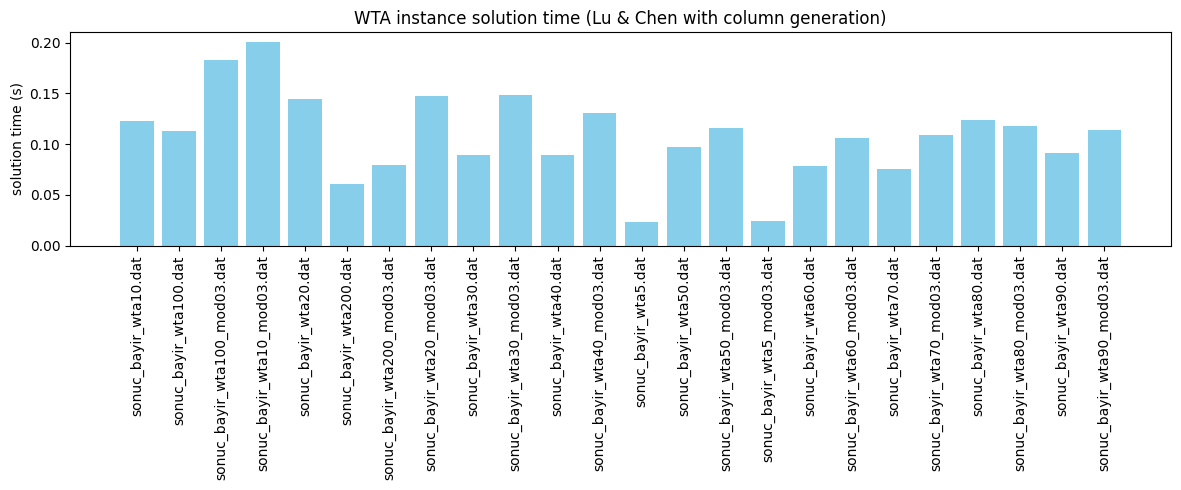

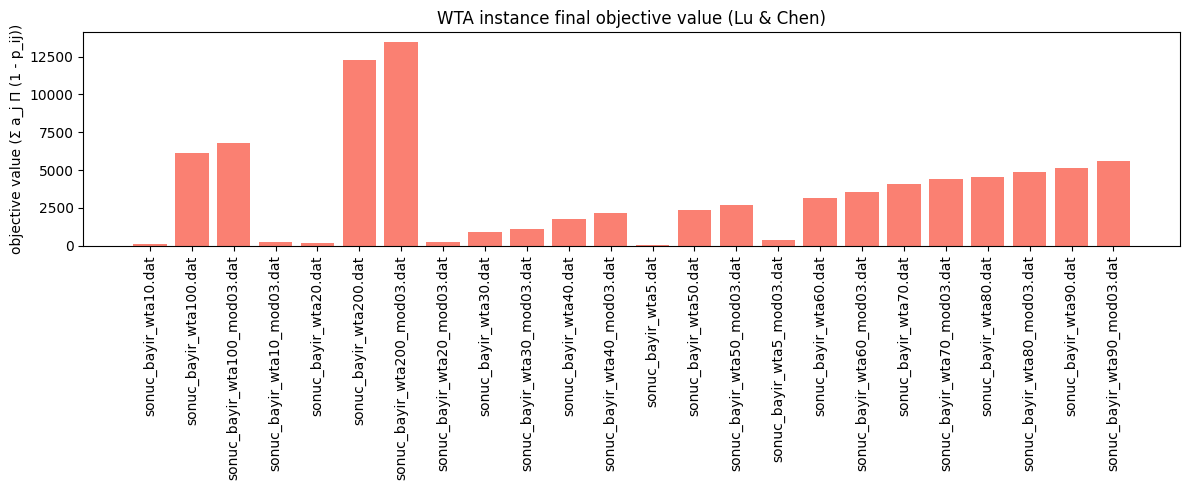

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

# === Parameters ===
input_dir = "/content/drive/MyDrive/instancje"
max_variables = 1000

# === Tracking ===
times = []
objectives = []
instance_names = []

# === Loop over instances ===
for filename in sorted(os.listdir(input_dir)):
    if filename.endswith(".dat"):
        filepath = os.path.join(input_dir, filename)

        try:
            N, M, target_value, pk = load_and_shrink_instance(filepath, max_variables=max_variables)

            print(f"\nSolving: {filename} | N={N}, M={M}")
            duration, obj = solve_wta_column_generation(N, M, target_value, pk)

            times.append(duration)
            objectives.append(obj)
            instance_names.append(filename)

        except Exception as e:
            print(f"Failed to process {filename}: {e}")
            continue

# === Plot 1: solution time ===
plt.figure(figsize=(12, 5))
plt.bar(instance_names, times, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("solution time (s)")
plt.title("WTA instance solution time (Lu & Chen with column generation)")
plt.tight_layout()
plt.show()

# === Plot 2: objective values ===
plt.figure(figsize=(12, 5))
plt.bar(instance_names, objectives, color='salmon')
plt.xticks(rotation=90)
plt.ylabel("objective value (Σ a_j Π (1 - p_ij))")
plt.title("WTA instance final objective value (Lu & Chen)")
plt.tight_layout()
plt.show()


# 6) Final time comparaison - P1,P2 and Lu & Chen


📦 Processing sonuc_bayir_wta10.dat
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta100.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta100_mod03.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta10_mod03.dat
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta20.dat
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta200.dat
Instance too big (N=200, M=200, vars=80000).
Cut to N=22, M=22 (vars=96

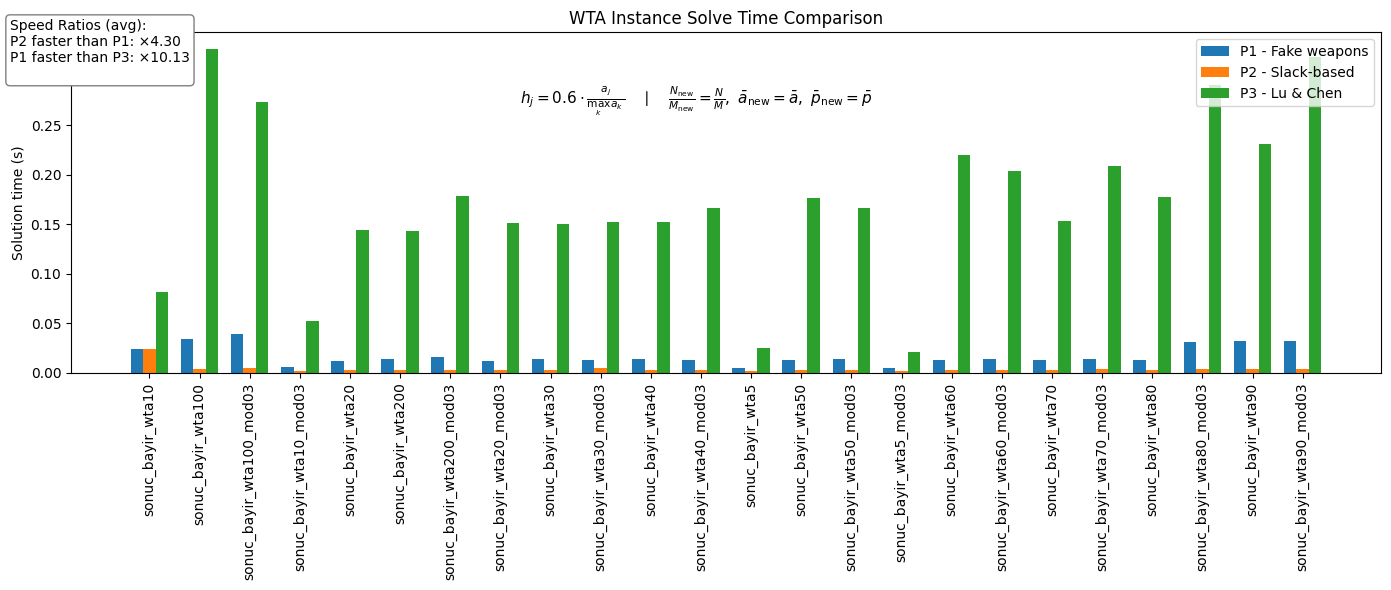

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

def p1_solution(N, M_real, pk_real, target_value):
    max_a = max(target_value)
    h = [0.60 * a / max_a for a in target_value]

    M_fake = M_real
    M = M_real + M_fake
    fake_pk = np.full((M_fake, N), 0.999999)
    pk = np.vstack([pk_real, fake_pk])

    model = Model(name="WTA_P1")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk[i][j]) for i in range(M))
        rhs = math.log(1 - h[j])
        model.add_constraint(lhs <= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    fake_weapon_usage = model.sum(x[i][j] for i in range(M_real, M) for j in range(N))
    model.minimize(fake_weapon_usage)

    return model

def p2_solution(N, M_real, pk_real, target_value):
    max_a = max(target_value)
    h = [0.60 * a / max_a for a in target_value]

    model = Model(name="WTA_P2")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M_real)]

    e = model.continuous_var(lb=0, name="e")

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk_real[i][j]) for i in range(M_real))
        rhs = math.log(1 - h[j]) - e
        model.add_constraint(lhs >= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    model.minimize(e)
    return model

# === Benchmark ===

input_dir = "/content/drive/MyDrive/instancje"
max_variables = 1000

instances = []
times_p1 = []
times_p2 = []
times_p3 = []

for filename in sorted(os.listdir(input_dir)):
    if not filename.endswith(".dat"):
        continue

    filepath = os.path.join(input_dir, filename)
    print(f"\n📦 Processing {filename}")
    try:
        N, M, target_value, pk = load_and_shrink_instance_V2(filepath, max_variables=max_variables)

        print("  🔧 Solving with P1 (fake weapons)...")
        model1 = p1_solution(N, M, pk, target_value)
        start = time.time()
        model1.solve(log_output=False)
        times_p1.append(time.time() - start)

        print("  🔧 Solving with P2 (slack-based)...")
        model2 = p2_solution(N, M, pk, target_value)
        start = time.time()
        model2.solve(log_output=False)
        times_p2.append(time.time() - start)

        print("Solving with P3 (Lu & Chen)...")
        start = time.time()
        _, _ = solve_wta_column_generation(N, M, target_value, pk)
        times_p3.append(time.time() - start)

        instances.append(filename.replace(".dat", ""))

    except Exception as e:
        print(f"Failed on {filename}: {e}")
        continue

# === Averages

mean_p1 = np.mean(times_p1)
mean_p2 = np.mean(times_p2)
mean_p3 = np.mean(times_p3)

ratio_p2_vs_p1 = mean_p1 / mean_p2 if mean_p2 != 0 else float("inf")
ratio_p1_vs_p3 = mean_p3 / mean_p1 if mean_p1 != 0 else float("inf")

# === Plot

x = np.arange(len(instances))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, times_p1, width, label="P1 - Fake weapons")
plt.bar(x,         times_p2, width, label="P2 - Slack-based")
plt.bar(x + width, times_p3, width, label="P3 - Lu & Chen")

plt.xticks(x, instances, rotation=90)
plt.ylabel("Solution time (s)")
plt.title("WTA Instance Solve Time Comparison")

# Top-left: ratios
speed_text = f"""Speed Ratios (avg):
P2 faster than P1: ×{ratio_p2_vs_p1:.2f}
P1 faster than P3: ×{ratio_p1_vs_p3:.2f}
"""
plt.gcf().text(0.01, 0.96, speed_text, fontsize=10, va='top', ha='left', bbox=dict(boxstyle="round", fc="white", ec="gray"))

# Top-center: h formula and shrink info
center_text = r"""$h_j = 0.6 \cdot \frac{a_j}{\max_k a_k} \quad \mid \quad \frac{N_\mathrm{new}}{M_\mathrm{new}} = \frac{N}{M},\ \bar{a}_\mathrm{new} = \bar{a},\ \bar{p}_\mathrm{new} = \bar{p}$"""

plt.gcf().text(0.5, 0.85, center_text, fontsize=11, va='top', ha='center')

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



📦 Processing sonuc_bayir_wta10.dat
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta100.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta100_mod03.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta10_mod03.dat
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta20.dat
  🔧 Solving with P1 (fake weapons)...
  🔧 Solving with P2 (slack-based)...
  🔧 Solving with P3 (Lu & Chen)...

📦 Processing sonuc_bayir_wta200.dat
Instance too big (N=200, M=200, vars=80000).
Cut to N=22, M=22 (vars=96

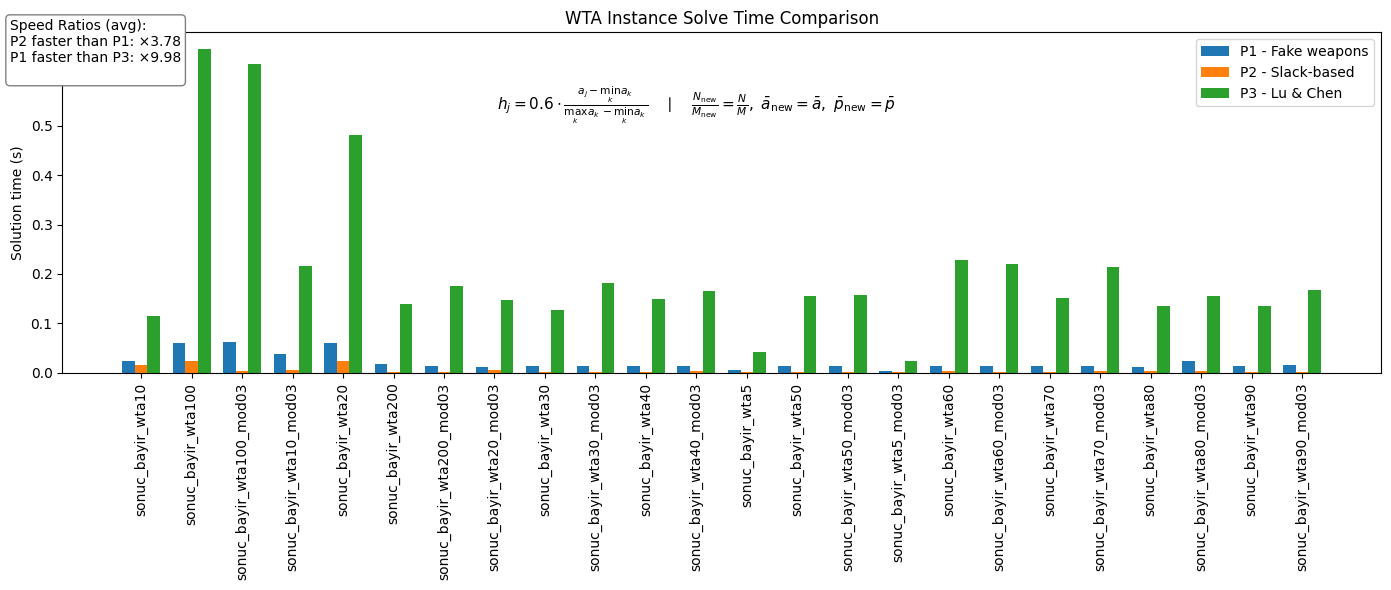

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

def p1_solution(N, M_real, pk_real, target_value):
    max_a = max(target_value)
    min_a = min(target_value)

    h = [0.6*(a - min_a) / (max_a - min_a) if max_a > min_a else 0.0 for a in target_value]

    M_fake = M_real
    M = M_real + M_fake
    fake_pk = np.full((M_fake, N), 0.999999)
    pk = np.vstack([pk_real, fake_pk])

    model = Model(name="WTA_P1")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk[i][j]) for i in range(M))
        rhs = math.log(1 - h[j])
        model.add_constraint(lhs <= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    fake_weapon_usage = model.sum(x[i][j] for i in range(M_real, M) for j in range(N))
    model.minimize(fake_weapon_usage)

    return model

def p2_solution(N, M_real, pk_real, target_value):

    min_a = min(target_value)
    max_a = max(target_value)
    h = [0.6*(a - min_a) / (max_a - min_a) if max_a > min_a else 0.0 for a in target_value]


    model = Model(name="WTA_P2")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M_real)]

    e = model.continuous_var(lb=0, name="e")

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk_real[i][j]) for i in range(M_real))
        rhs = math.log(1 - h[j]) - e
        model.add_constraint(lhs >= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    model.minimize(e)
    return model

# === Benchmark ===

input_dir = "/content/drive/MyDrive/instancje"
max_variables = 1000

instances = []
times_p1 = []
times_p2 = []
times_p3 = []

for filename in sorted(os.listdir(input_dir)):
    if not filename.endswith(".dat"):
        continue

    filepath = os.path.join(input_dir, filename)
    print(f"\nProcessing {filename}")
    try:
        N, M, target_value, pk = load_and_shrink_instance_V2(filepath, max_variables=max_variables)

        print(" Solving with P1 (fake weapons)...")
        model1 = p1_solution(N, M, pk, target_value)
        start = time.time()
        model1.solve(log_output=False)
        times_p1.append(time.time() - start)

        print("Solving with P2 (slack-based)...")
        model2 = p2_solution(N, M, pk, target_value)
        start = time.time()
        model2.solve(log_output=False)
        times_p2.append(time.time() - start)

        print("Solving with P3 (Lu & Chen)...")
        start = time.time()
        _, _ = solve_wta_column_generation(N, M, target_value, pk)
        times_p3.append(time.time() - start)

        instances.append(filename.replace(".dat", ""))

    except Exception as e:
        print(f"Failed on {filename}: {e}")
        continue

# === Averages

mean_p1 = np.mean(times_p1)
mean_p2 = np.mean(times_p2)
mean_p3 = np.mean(times_p3)

ratio_p2_vs_p1 = mean_p1 / mean_p2 if mean_p2 != 0 else float("inf")
ratio_p1_vs_p3 = mean_p3 / mean_p1 if mean_p1 != 0 else float("inf")

# === Plot

x = np.arange(len(instances))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, times_p1, width, label="P1 - Fake weapons")
plt.bar(x,         times_p2, width, label="P2 - Slack-based")
plt.bar(x + width, times_p3, width, label="P3 - Lu & Chen")

plt.xticks(x, instances, rotation=90)
plt.ylabel("Solution time (s)")
plt.title("WTA Instance Solve Time Comparison")

# Top-left: ratios
speed_text = f"""Speed Ratios (avg):
P2 faster than P1: ×{ratio_p2_vs_p1:.2f}
P1 faster than P3: ×{ratio_p1_vs_p3:.2f}
"""
plt.gcf().text(0.01, 0.96, speed_text, fontsize=10, va='top', ha='left', bbox=dict(boxstyle="round", fc="white", ec="gray"))

# Top-center: h formula and shrink info
center_text = r"""$h_j = 0.6 \cdot \frac{a_j - \min_k a_k}{\max_k a_k - \min_k a_k} \quad \mid \quad \frac{N_\mathrm{new}}{M_\mathrm{new}} = \frac{N}{M},\ \bar{a}_\mathrm{new} = \bar{a},\ \bar{p}_\mathrm{new} = \bar{p}$"""


plt.gcf().text(0.5, 0.85, center_text, fontsize=11, va='top', ha='center')

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


# 6.1) P1,P2, Lu & Chen Final expected value comparaison


📦 Processing sonuc_bayir_wta10.dat
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta100.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta100_mod03.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta10_mod03.dat
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta20.dat
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta200.dat
Instance too big (N=200, M=200, vars=80000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta200_mod03.dat
Instance too big (N=200, M=200, vars=80000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Process

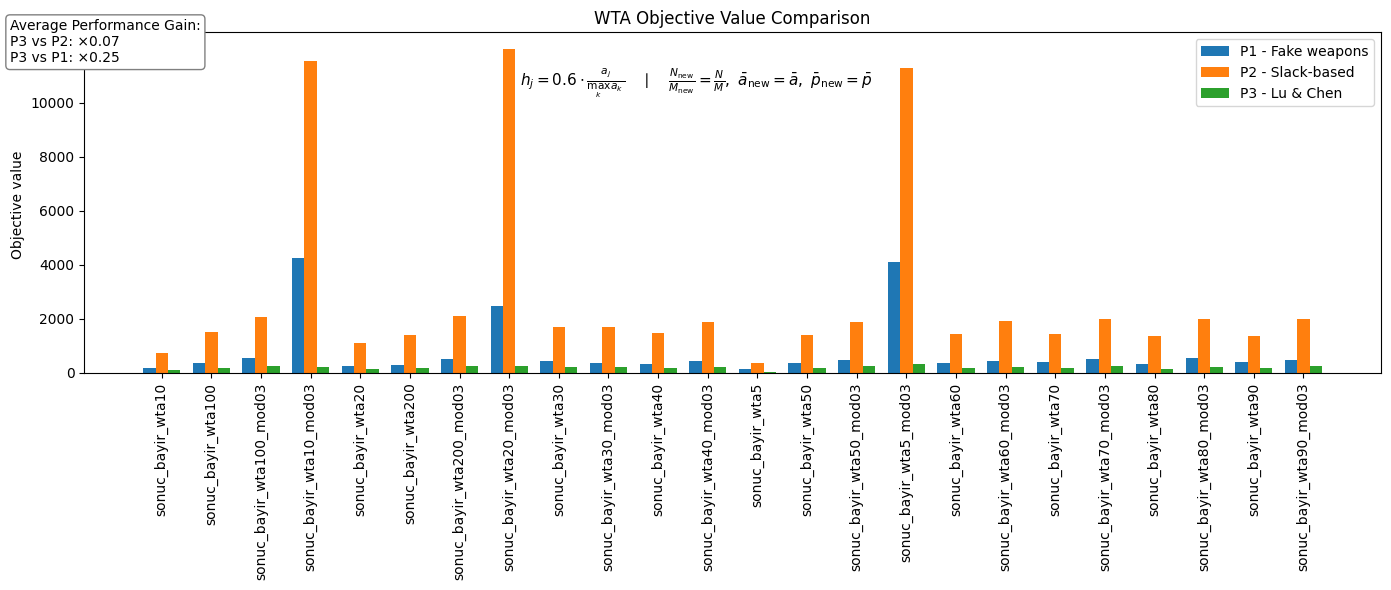

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

# === Define P1 and P2 ===

def p1_solution(N, M_real, pk_real, target_value):
    h = [0.60 * a / max_a for a in target_value]


    M_fake = M_real
    M = M_real + M_fake
    fake_pk = np.full((M_fake, N), 0.999999)
    pk = np.vstack([pk_real, fake_pk])

    model = Model(name="WTA_P1")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk[i][j]) for i in range(M))
        rhs = math.log(1 - h[j])
        model.add_constraint(lhs <= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    fake_weapon_usage = model.sum(x[i][j] for i in range(M_real, M) for j in range(N))
    model.minimize(fake_weapon_usage)

    return model, x, pk


def p2_solution(N, M_real, pk_real, target_value):

    h = [0.60 * a / max_a for a in target_value]

    model = Model(name="WTA_P2")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M_real)]

    e = model.continuous_var(lb=0, name="e")

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk_real[i][j]) for i in range(M_real))
        rhs = math.log(1 - h[j]) - e
        model.add_constraint(lhs >= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    model.minimize(e)

    return model, x, pk_real

# === Parameters ===

input_dir = "/content/drive/MyDrive/instancje"
max_variables = 1000

instances = []
objectives_p1 = []
objectives_p2 = []
objectives_p3 = []

# === Process ===

for filename in sorted(os.listdir(input_dir)):
    if not filename.endswith(".dat"):
        continue

    filepath = os.path.join(input_dir, filename)
    print(f"\nProcessing {filename}")

    try:
        N, M, target_value, pk = load_and_shrink_instance_V2(filepath, max_variables=max_variables)

        print(" Solving with P1")
        model1, x1, pk1 = p1_solution(N, M, pk, target_value)
        solution1 = model1.solve(log_output=False)

        expected1 = 0
        if solution1:
            for j in range(N):
                survival = 1.0
                for i in range(M):
                    if x1[i][j].solution_value > 0.5:
                        survival *= (1 - pk[i][j])
                expected1 += target_value[j] * survival
        objectives_p1.append(expected1)

        print(" Solving with P2")
        model2, x2, pk2 = p2_solution(N, M, pk, target_value)
        solution2 = model2.solve(log_output=False)

        expected2 = 0
        if solution2:
            for j in range(N):
                survival = 1.0
                for i in range(M):
                    if x2[i][j].solution_value > 0.5:
                        survival *= (1 - pk[i][j])
                expected2 += target_value[j] * survival
        objectives_p2.append(expected2)

        print(" Solving with P3")
        _, expected3 = solve_wta_column_generation(N, M, target_value, pk)
        objectives_p3.append(expected3)

        instances.append(filename.replace(".dat", ""))

    except Exception as e:
        print(f"Failed on {filename}: {e}")
        continue

# === Compute Ratios ===

mean_p1 = np.mean(objectives_p1)
mean_p2 = np.mean(objectives_p2)
mean_p3 = np.mean(objectives_p3)

ratio_p3_vs_p2 = mean_p3 / mean_p2 if mean_p2 != 0 else float("inf")
ratio_p3_vs_p1 = mean_p3 / mean_p1 if mean_p1 != 0 else float("inf")

# === Plot ===

x = np.arange(len(instances))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, objectives_p1, width, label="P1 - Fake weapons")
plt.bar(x,         objectives_p2, width, label="P2 - Slack-based")
plt.bar(x + width, objectives_p3, width, label="P3 - Lu & Chen")

plt.xticks(x, instances, rotation=90)
plt.ylabel("Objective value ")
plt.title("WTA Objective Value Comparison")

# === Top-left annotations ===
score_text = f"""Average Performance Gain:
P3 vs P2: ×{ratio_p3_vs_p2:.2f}
P3 vs P1: ×{ratio_p3_vs_p1:.2f}"""
plt.gcf().text(0.01, 0.96, score_text, fontsize=10, va='top', ha='left', bbox=dict(boxstyle="round", fc="white", ec="gray"))

# === Top-center formula ===
center_text = r"""$h_j = 0.6 \cdot \frac{a_j}{\max_k a_k} \quad \mid \quad \frac{N_\mathrm{new}}{M_\mathrm{new}} = \frac{N}{M},\ \bar{a}_\mathrm{new} = \bar{a},\ \bar{p}_\mathrm{new} = \bar{p}$"""
plt.gcf().text(0.5, 0.88, center_text, fontsize=11, va='top', ha='center')

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



📦 Processing sonuc_bayir_wta10.dat
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta100.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta100_mod03.dat
Instance too big (N=100, M=100, vars=20000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta10_mod03.dat
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta20.dat
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta200.dat
Instance too big (N=200, M=200, vars=80000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Processing sonuc_bayir_wta200_mod03.dat
Instance too big (N=200, M=200, vars=80000).
Cut to N=22, M=22 (vars=968)
  🔧 Solving with P1
  🔧 Solving with P2
  🔧 Solving with P3

📦 Process

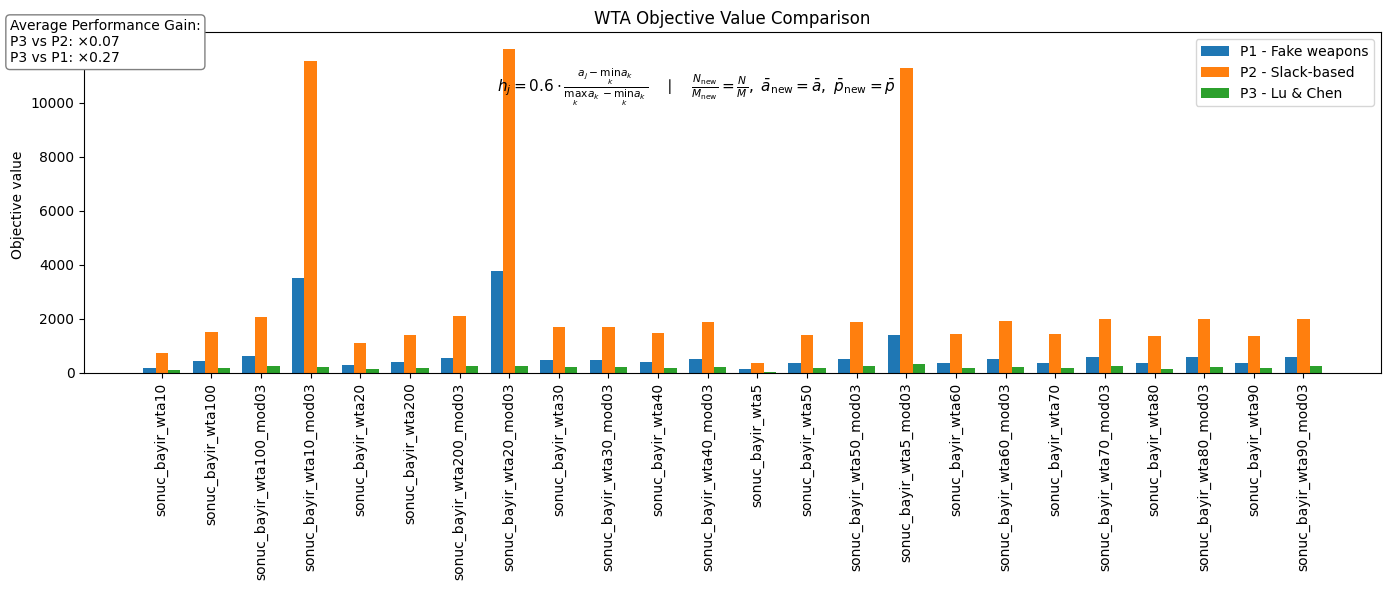

In [ ]:
import os
import ast
import time
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math

# === Define P1 and P2 ===

def p1_solution(N, M_real, pk_real, target_value):
    min_a = min(target_value)
    max_a = max(target_value)
    h = [0.60 * (a - min_a) / (max_a - min_a) for a in target_value]

    M_fake = M_real
    M = M_real + M_fake
    fake_pk = np.full((M_fake, N), 0.999999)
    pk = np.vstack([pk_real, fake_pk])

    model = Model(name="WTA_P1")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M)]

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk[i][j]) for i in range(M))
        rhs = math.log(1 - h[j])
        model.add_constraint(lhs <= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    fake_weapon_usage = model.sum(x[i][j] for i in range(M_real, M) for j in range(N))
    model.minimize(fake_weapon_usage)

    return model, x, pk


def p2_solution(N, M_real, pk_real, target_value):
    min_a = min(target_value)
    max_a = max(target_value)
    h = [0.60 * (a - min_a) / (max_a - min_a) for a in target_value]

    model = Model(name="WTA_P2")
    model.context.solver.agent = "cplex"
    x = [[model.binary_var(name=f"x_{i}_{j}") for j in range(N)] for i in range(M_real)]

    e = model.continuous_var(lb=0, name="e")

    for j in range(N):
        lhs = model.sum(x[i][j] * math.log(1 - pk_real[i][j]) for i in range(M_real))
        rhs = math.log(1 - h[j]) - e
        model.add_constraint(lhs >= rhs)

    for i in range(M_real):
        model.add_constraint(model.sum(x[i][j] for j in range(N)) <= 1)

    model.minimize(e)

    return model, x, pk_real

# === Parameters ===

input_dir = "/content/drive/MyDrive/instancje"
max_variables = 1000

instances = []
objectives_p1 = []
objectives_p2 = []
objectives_p3 = []

# === Process ===

for filename in sorted(os.listdir(input_dir)):
    if not filename.endswith(".dat"):
        continue

    filepath = os.path.join(input_dir, filename)
    print(f"\n📦 Processing {filename}")

    try:
        N, M, target_value, pk = load_and_shrink_instance_V2(filepath, max_variables=max_variables)

        print("  🔧 Solving with P1")
        model1, x1, pk1 = p1_solution(N, M, pk, target_value)
        solution1 = model1.solve(log_output=False)

        expected1 = 0
        if solution1:
            for j in range(N):
                survival = 1.0
                for i in range(M):
                    if x1[i][j].solution_value > 0.5:
                        survival *= (1 - pk[i][j])
                expected1 += target_value[j] * survival
        objectives_p1.append(expected1)

        print(" Solving with P2")
        model2, x2, pk2 = p2_solution(N, M, pk, target_value)
        solution2 = model2.solve(log_output=False)

        expected2 = 0
        if solution2:
            for j in range(N):
                survival = 1.0
                for i in range(M):
                    if x2[i][j].solution_value > 0.5:
                        survival *= (1 - pk[i][j])
                expected2 += target_value[j] * survival
        objectives_p2.append(expected2)

        print("  Solving with P3")
        _, expected3 = solve_wta_column_generation(N, M, target_value, pk)
        objectives_p3.append(expected3)

        instances.append(filename.replace(".dat", ""))

    except Exception as e:
        print(f" Failed on {filename}: {e}")
        continue

# === Compute Ratios ===

mean_p1 = np.mean(objectives_p1)
mean_p2 = np.mean(objectives_p2)
mean_p3 = np.mean(objectives_p3)

ratio_p3_vs_p2 = mean_p3 / mean_p2 if mean_p2 != 0 else float("inf")
ratio_p3_vs_p1 = mean_p3 / mean_p1 if mean_p1 != 0 else float("inf")

# === Plot ===

x = np.arange(len(instances))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, objectives_p1, width, label="P1 - Fake weapons")
plt.bar(x,         objectives_p2, width, label="P2 - Slack-based")
plt.bar(x + width, objectives_p3, width, label="P3 - Lu & Chen")

plt.xticks(x, instances, rotation=90)
plt.ylabel("Objective value ")
plt.title("WTA Objective Value Comparison")

# === Top-left annotations ===
score_text = f"""Average Performance Gain:
P3 vs P2: ×{ratio_p3_vs_p2:.2f}
P3 vs P1: ×{ratio_p3_vs_p1:.2f}"""
plt.gcf().text(0.01, 0.96, score_text, fontsize=10, va='top', ha='left', bbox=dict(boxstyle="round", fc="white", ec="gray"))

# === Top-center formula ===
center_text = r"""$h_j = 0.6 \cdot \frac{a_j - \min_k a_k}{\max_k a_k - \min_k a_k} \quad \mid \quad \frac{N_\mathrm{new}}{M_\mathrm{new}} = \frac{N}{M},\ \bar{a}_\mathrm{new} = \bar{a},\ \bar{p}_\mathrm{new} = \bar{p}$"""
plt.gcf().text(0.5, 0.88, center_text, fontsize=11, va='top', ha='center')

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
